### Table of Contents

[1. Project Overview](#1-Project-Overview)

[Aspect-Based Sentiment Analysis](#Aspect-Based-Sentiment-Analysis)  
[Introduction](#Introduction)  
[Idea Behind the Project](#Idea-Behind-the-Project)  
[How the Project Works in a Real-Life Scenario](#How-the-Project-Works-in-a-Real-Life-Scenario)  

[2. Data Analysis & Processing](#2-Data-Analysis-&-Processing)

[Natural Language Processing](#Natural-Language-Processing)  

[3. Modeling-&-Evaluation](#3-Modeling-&-Evaluation)

[Machine Learning](#Machine-Learning)  
[Further Performance Improvement](#Further-Performance-Improvement)  
[Showcase](#Showcase)  
[Practical Use](#Practical-Use)  

[4. Conclusion](#4-Conclusion)



## 1. [Project Overview](#Project-Overview) 

### **Aspect-Based Sentiment Analysis**

#### **Research Question**

##### How can aspect-based sentiment analysis help identify what customers specifically like or dislike in hotel reviews, and how accurately can machine learning models classify those sentiments?

#### **Summary**
##### We applied natural language processing to explore customer reviews and extract commonly mentioned aspects and associated opinion words. This gave a better understanding of what matters most to guests. Based on this, we then built and fine-tuned multiple machine learning models to classify review sentiments (positive, neutral, negative), achieving strong and reliable performance.

### **Introduction**
##### Customer reviews play a major role in influencing future bookings in the hotel industry. While overall ratings are useful, they don’t reveal exactly what customers liked or disliked. A review might praise the hotel’s location but criticize its cleanliness. This is where Aspect-Based Sentiment Analysis (ABSA) becomes important. Instead of just labeling a review as neutral, positive or negative, ABSA breaks it down to understand the sentiment toward specific aspects like service, location, or food. This project uses reviews from TripAdvisor to perform ABSA and trains machine learning models to classify the overall sentiment of each review.

#### **What problem does it solve?**
##### Hotel managers often don’t have time to read every review. This project helps by automatically summarizing guest opinions by topic (e.g. staff, room, cleanliness) and detecting the overall sentiment. It makes it easier to spot problems early and respond to guest feedback more effectively.

### **Idea behind the project**
##### The main idea is to go deeper than basic sentiment analysis. Instead of just saying a review is "neutal", “positive” or “negative”, we try to answer: positive or negative about what? By identifying specific aspects (like staff, room, or cleanliness) and matching them with adjectives or verbs (like “dirty,” “helpful,” or “amazing”), we can understand exactly what customers care about. This helps hotel businesses take specific actions rather than guessing from overall ratings.

##### On top of that, we train machine learning models to automatically detect the sentiment of new reviews. This combination of aspect-level insights and automatic classification helps hotel businesses react faster, catch dissatisfaction early, and improve service based on real guest feedback, and not just star ratings.

### **How the project works in real-life scenario?**

##### We first detect the overall sentiment because it helps quickly flag reviews that may require attention. Once those are filtered, aspect-level analysis provides a deeper understanding of what exactly caused satisfaction or dissatisfaction.

##### -	A hotel, especially larger ones or those in main tourist areas, receives hundreds of guest reviews, often without structured star ratings. These can come from platforms like tripadvisor or booking.com but also from internal surveys, emails, or chat systems, where guests leave only free-text comments.
##### -	The system first uses machine learning to automatically tag each review as positive, neutral, or negative.
##### -	Then, it applies aspect-based sentiment analysis to identify key topics (like food, room, or staff) and determine which aspects were liked or disliked.
##### -	It highlights top positive and negative aspects along with the most frequent opinion words used by guests.
##### -	This helps hotel managers act quickly, improve service where it matters most, and monitor satisfaction trends over time — even when no explicit ratings are provided.

Note:
In this project, we explored aspects and keywords before training sentiment models.
This helped us:

-	Understand which topics (e.g., room, staff, location) dominate the reviews.
-	Spot issues like class imbalance (e.g. too many positive reviews).
-	Decide how to clean, balance, and prepare the data more effectively.

In [1]:
#libraries used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import spacy
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,    ConfusionMatrixDisplay
import spacy.cli
#spacy.cli.download("en_core_web_sm")
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier





In [2]:
#load dataset 
trip_advisor = pd.read_csv("tripadvisor_hotel_reviews.csv")
trip_advisor.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


##### We are going on with converting numerical ratings (1 to 5) into sentiment categories — positive, neutral, or negative — and adds a new column called 'Sentiment' to the dataset which would be used as a dependent variable in a ML Models.

In [3]:
#create simple map to make a new column out of Rating column which is Sentiment Column for ML Models
rating_map = {5 : 'positive',
              4 : 'positive',
              3 : 'neutral',
              2 : 'negative',
              1 : 'negative'}

trip_advisor['Sentiment'] = trip_advisor['Rating'].map(rating_map)
trip_advisor.head()

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not 4* experience hotel monaco seat...,3,neutral
3,"unique, great stay, wonderful time hotel monac...",5,positive
4,"great stay great stay, went seahawk game aweso...",5,positive


##### This block performs several text preprocessing steps to clean the hotel reviews and prepare them for analysis. It includes converting text to lowercase, removing punctuation, numbers, extra spaces, and (optionally) stop words. These steps help make the text uniform and easier for the model to understand.

In [4]:
#preprocessing steps to clean the text for future use.

#convert characters to lowercase
trip_advisor['Review'] = trip_advisor['Review'].str.lower()

#remove punctuation and unnecessary symbols 
trip_advisor['Review'] = trip_advisor['Review'].apply(lambda x : re.sub(f"[{re.escape(string.punctuation)}]", "", x))

#remove numbers present in the text 
trip_advisor['Review'] = trip_advisor['Review'].apply(lambda x : re.sub(r'\d+', "", x).strip())

#remove whitespaces from the text
trip_advisor['Review'] = trip_advisor['Review'].apply(lambda x : re.sub(r'\s+', " ", x).strip())

#Here all the stop words would be removed from the text
# stop_words = set(stopwords.words('english'))
# trip_advisor['Review'] = trip_advisor['Review'].apply(lambda x : ' '.join([word for word in x.split() if word not in stop_words]).strip())


##### This block converts the cleaned text reviews into numerical vectors using TF-IDF (Term Frequency–Inverse Document Frequency). This helps represent the importance of words in each review while ignoring common stopwords. The resulting matrix is used as input for machine learning models.

In [5]:
#convert text into vectors
data = trip_advisor.copy()
vectorizer = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = vectorizer.fit_transform(data['Review'])
tfidf_matrix.shape

(20491, 75811)

##### This block visualizes the distribution of ratings in the dataset. It creates a bar chart showing how frequently each rating (1 to 5) appears. The chart is labeled with the exact count of reviews for each rating. This helps to understand the overall spread of ratings in the dataset.

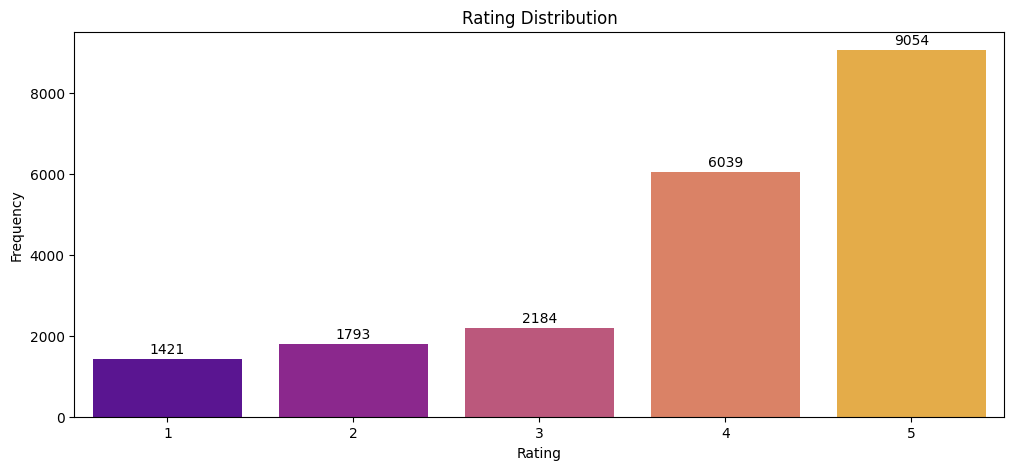

In [6]:
rating_count = pd.DataFrame(data['Rating'].value_counts()).reset_index()
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = rating_count['Rating'], y = rating_count['count'], palette = 'plasma')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
for i in range(5):
    bars = ax.containers[i]
    plt.bar_label(bars, labels = [int(bar.get_height()) for bar in bars], padding = 2, fontsize = 10, color = "black")
plt.show()

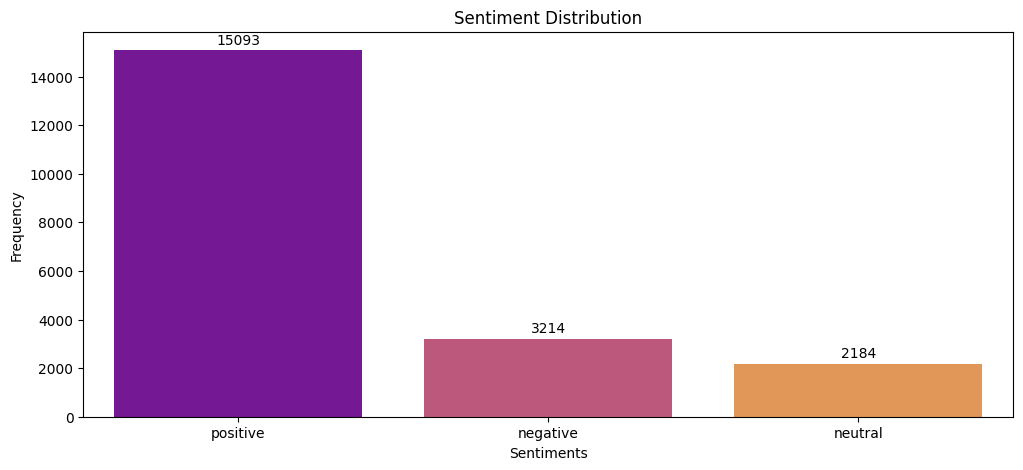

In [7]:
#plot distribution of the sentiments present in data
sentiment = pd.DataFrame(data['Sentiment'].value_counts()).reset_index()
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = sentiment['Sentiment'], y = sentiment['count'], palette = 'plasma')
plt.xlabel('Sentiments')
plt.ylabel("Frequency")
plt.title("Sentiment Distribution")
for i in range(3):
    bars = ax.containers[i]
    plt.bar_label(bars, labels = [int(bar.get_height()) for bar in bars], color = "black", padding = 2, fontsize = 10)
plt.show()

**Insights from rating and sentiment distributions:**

##### The majority of users gave high star ratings (4 or 5) and expressed positive sentiments (over 15.000 reviews). Means, there is a clear imbalance: only a small portion of reviews are negative (3.214) or neutral (2.184).

##### Even negative and neutral reviews are fewer, they are very important for improving service.We need to build models that can still find these less common but important opinions.

## 2. [Data Analysis & Processing](#Data-Analysis-&-Processing) 

### **Natural Language Processing**

In [8]:
trip_advisor.head(10)

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,positive
1,ok nothing special charge diamond member hilto...,2,negative
2,nice rooms not experience hotel monaco seattle...,3,neutral
3,unique great stay wonderful time hotel monaco ...,5,positive
4,great stay great stay went seahawk game awesom...,5,positive
5,love monaco staff husband stayed hotel crazy w...,5,positive
6,cozy stay rainy city husband spent nights mona...,5,positive
7,excellent staff housekeeping quality hotel cho...,4,positive
8,hotel stayed hotel monaco cruise rooms generou...,5,positive
9,excellent stayed hotel monaco past we delight ...,5,positive


##### Here, Part-of-Speech (POS) Tagging and Pattern Matching techniques are used to identify aspects (nouns) and their associated sentiments (adjectives) in the reviews. POS Tagging focuses on the syntactic structure to identify key parts of speech like nouns, adjectives, and adverbs, while Pattern Matching is used to detect specific patterns of dependency within the text. These approaches work together to extract as much information as possible from each review, ensuring no relevant details are missed.

In [9]:
#Part-Of-Speech Tagging to find out the aspects and their Literal Sentiments
nlp = spacy.load('en_core_web_sm')
aspect_sentiment = defaultdict(list)
for _, review in trip_advisor.iterrows():
    seen_pairs = set()
    POS = nlp(review['Review'])
    for token in POS:
        if token.pos_ == "NOUN":
            aspect = token.lemma_
            for child in token.children:
                if child.pos_ == "ADJ":
                    sentiment = child.text
                    pairs = (aspect, sentiment)
                    if pairs not in seen_pairs:
                        seen_pairs.add(pairs)
                        aspect_sentiment[aspect].append(sentiment)

        elif token.pos_ == "ADJ":
            sentiment = token.text
            for child in token.children:
                if child.pos_ == "NOUN":
                    aspect = child.lemma_
                    pairs = (aspect, sentiment)
                    if pairs not in seen_pairs:
                        seen_pairs.add(pairs)
                        aspect_sentiment[aspect].append(sentiment)

            if token.head.pos_ == "NOUN":
                aspect = token.head.lemma_
                pairs = (aspect, sentiment)
                if pairs not in seen_pairs:
                    seen_pairs.add(pairs)
                    aspect_sentiment[aspect].append(sentiment)



In [10]:
#print information about the structure of dictionary and the number of aspects present in data
print(f"Total aspects found: {len(aspect_sentiment)}\n")
print("Aspect : Sentiment\n")
for i, (aspect, sentiments) in enumerate(aspect_sentiment.items()):
    print(f"{aspect} : {sentiments[:10]}")
    if i >= 10:  
        break


Total aspects found: 13407

Aspect : Sentiment

parking : ['nice', 'expensive', 'clean', 'available', 'free', 'friendly', 'professional', 'tough', 'rude', 'clean']
deal : ['good', 'online', 'good', 'big', 'best', 'big', 'great', 'good', 'great', 'good']
evening : ['late', 'available', 'late', 'early', 'quiet', 'tight', 'small', 'wonderful', 'enjoyed', 'good']
review : ['previous', 'warwick', 'bad', 'good', 'positive', 'negative', 'disappointing', 'previous', 'best', 'clean']
room : ['quick', 'easy', 'disappointed', 'nonexistent', 'standard', 'great', 'nice', 'larger', 'easy', 'downside']
size : ['nice', 'decent', 'standard', 'good', 'worse', 'bigger', 'usual', 'great', 'normal', 'small']
bed : ['comfortable', 'comfortable', 'smart', 'comfortable', 'quick', 'tasty', 'comfortable', 'standard', 'clean', 'cool']
pillow : ['stiff', 'high', 'extra', 'extra', 'comfortable', 'new', 'clean', 'flat', 'extra', 'clean']
bang : ['loud', 'outfitted', 'good', 'excellent', 'best', 'best', 'better']
ne

In [11]:
#count how many times each aspect has been discussed in the all the reviews
aspect_count = Counter()
for aspect, sentiment in aspect_sentiment.items():
    aspect_count[aspect] = len(sentiment)

top_10_aspects = aspect_count.most_common(10)
top_aspects = pd.DataFrame(top_10_aspects, columns = ['Aspect', 'Count'])
print("The top Aspects discussed in the reviews are : ")
top_aspects

The top Aspects discussed in the reviews are : 


,Aspect,Count
0,room,24524
1,hotel,14344
2,staff,10006
3,location,8168
4,place,5573
5,time,5457
6,restaurant,4630
7,service,4544
8,bed,4230
9,bathroom,4168


##### We are going on to visualize the top 10 aspects (e.g., room, service, location) that appear most frequently in the reviews. It shows how often each aspect was mentioned, helping to identify which features of the hotel customers discuss the most.

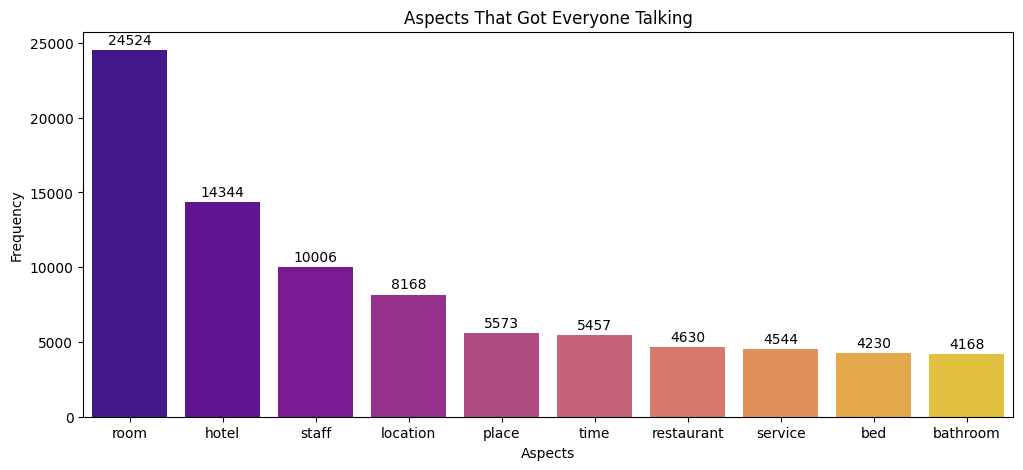

In [12]:
#plot the top 10 aspects and their counts using barplot
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = top_aspects['Aspect'], y = top_aspects['Count'], palette = 'plasma')
plt.xlabel("Aspects")
plt.ylabel("Frequency")
plt.title("Aspects That Got Everyone Talking")
for i in range(10):
    bars = ax.containers[i]
    ax.bar_label(bars, labels=[int(bar.get_height()) for bar in bars], fontsize=10, color='black', padding=2)
plt.show()

**Insight:**

##### The room, hotel(in general), staff and location are by far the most "relevant" talked-about topics. These are the areas guests care most about, where (service) improvements may have the biggest impact.

In [13]:
#count each sentiment in each aspect and then store into dictionary
aspect_sentiment_count = {}
for aspect, sentiment in aspect_sentiment.items():
    sentiment_count = Counter(sentiment)
    aspect_sentiment_count[aspect] = sentiment_count


##### We are going to extract the sentiment counts for each of the top aspects (e.g., room, service) top 10 most common sentiments associated with each aspect. For each aspect, the most frequent sentiments (positive or negative) are plotted showing which opinions are most often expressed.

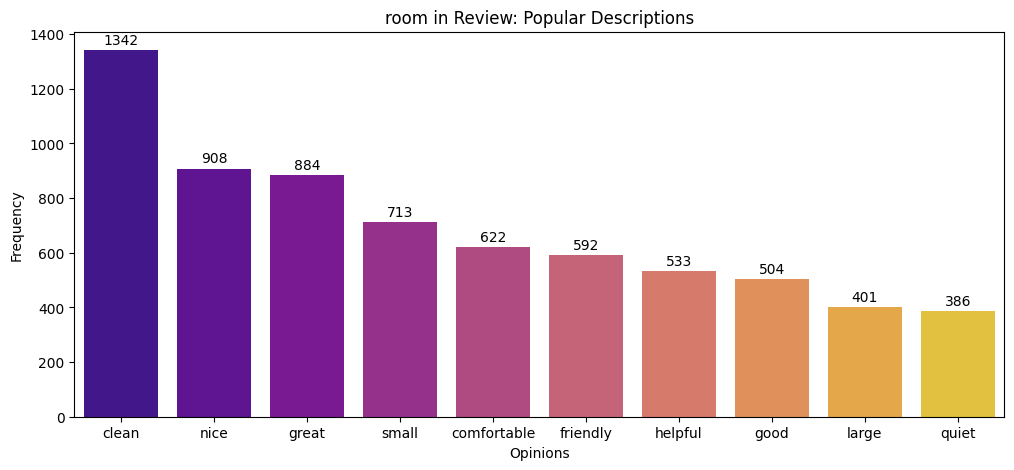

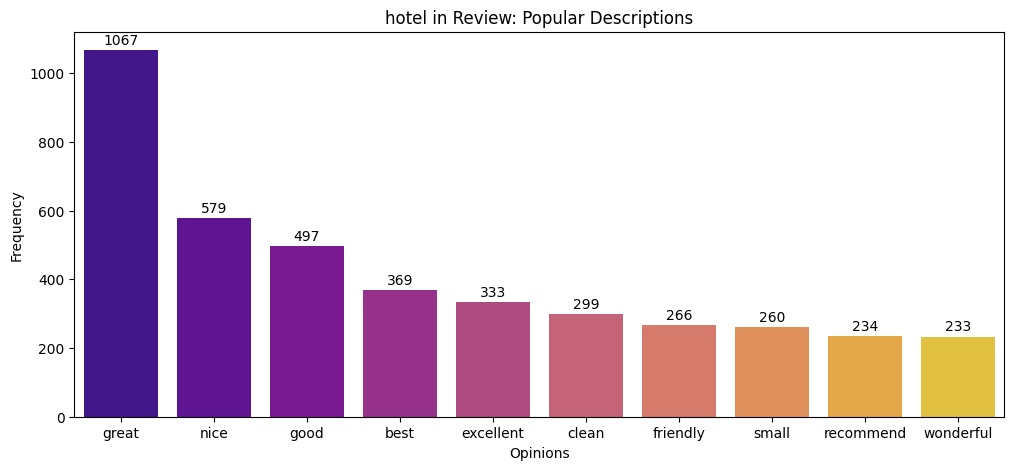

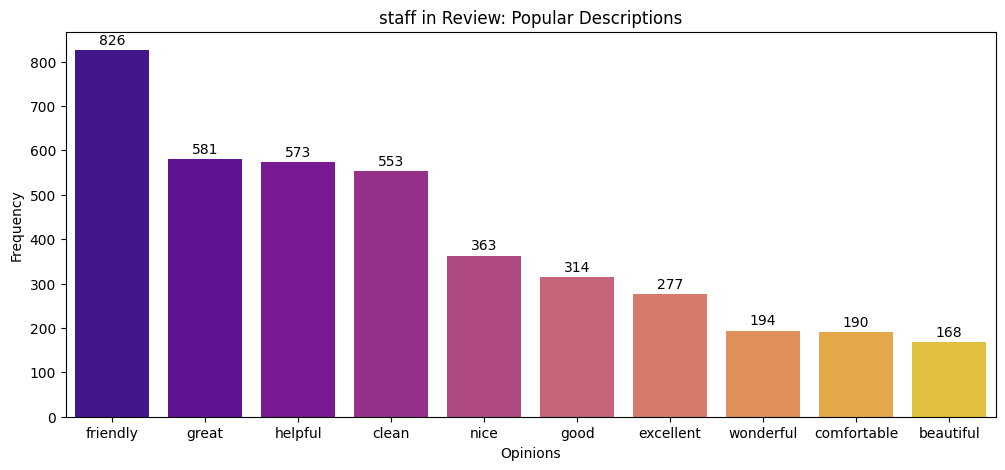

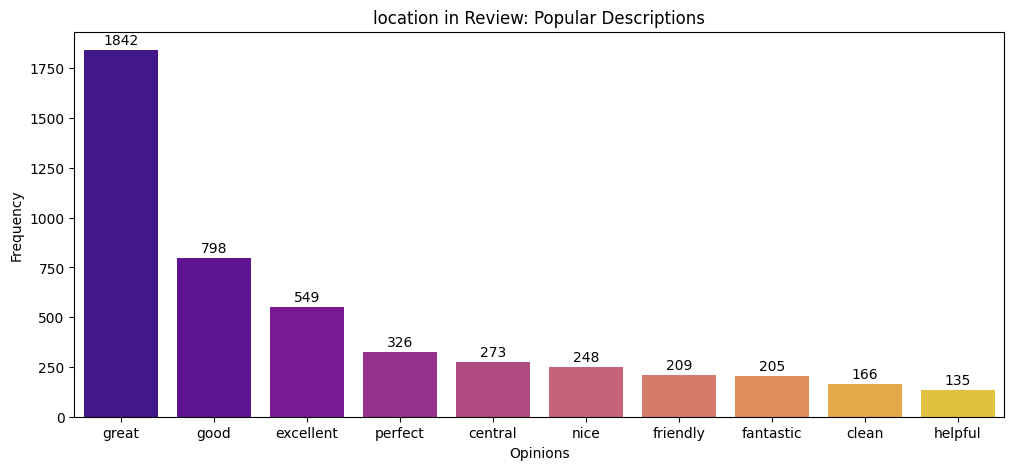

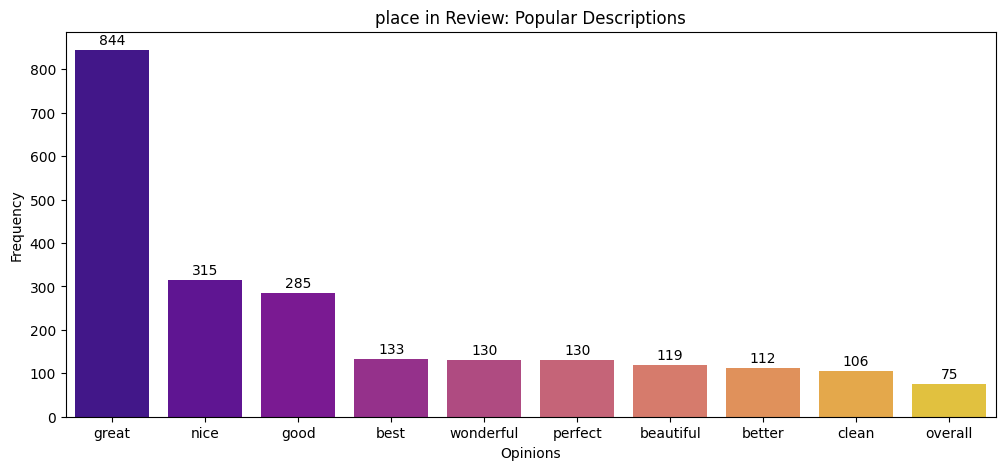

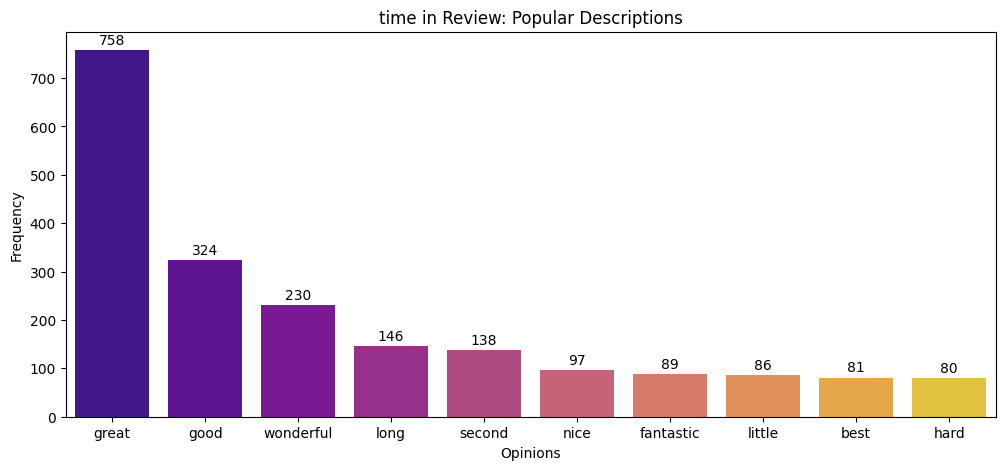

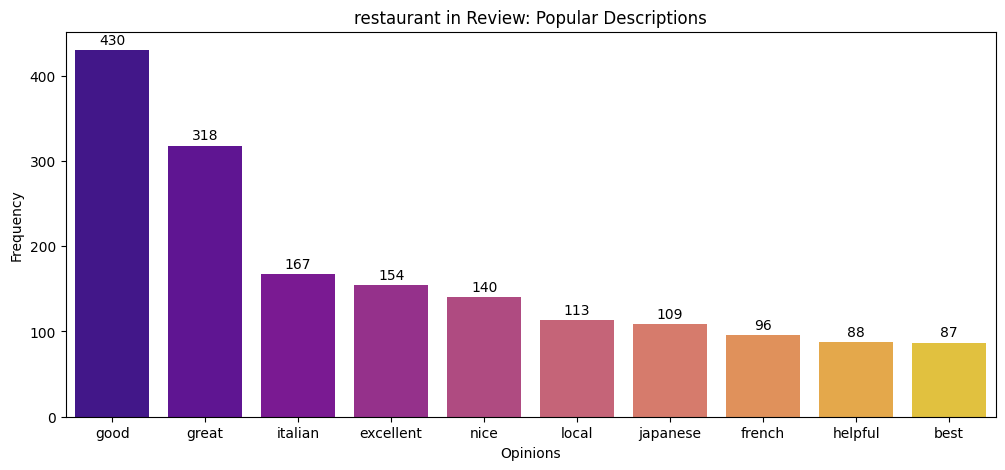

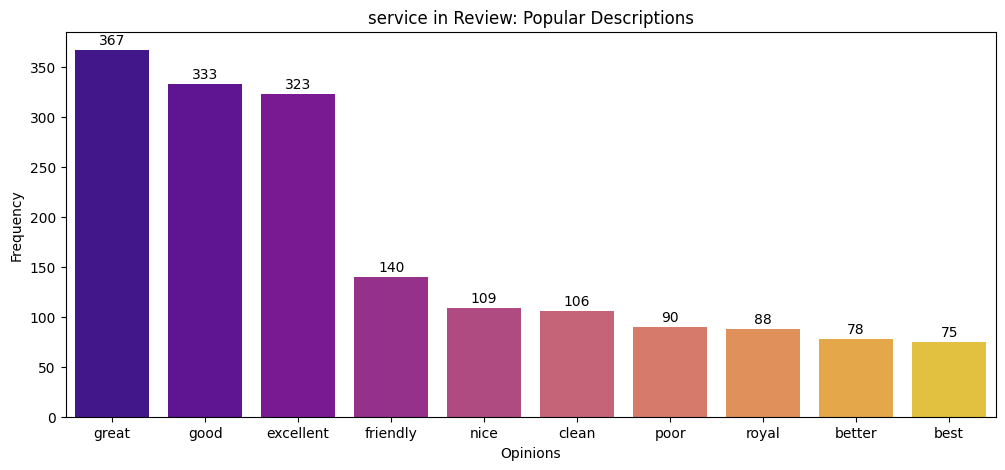

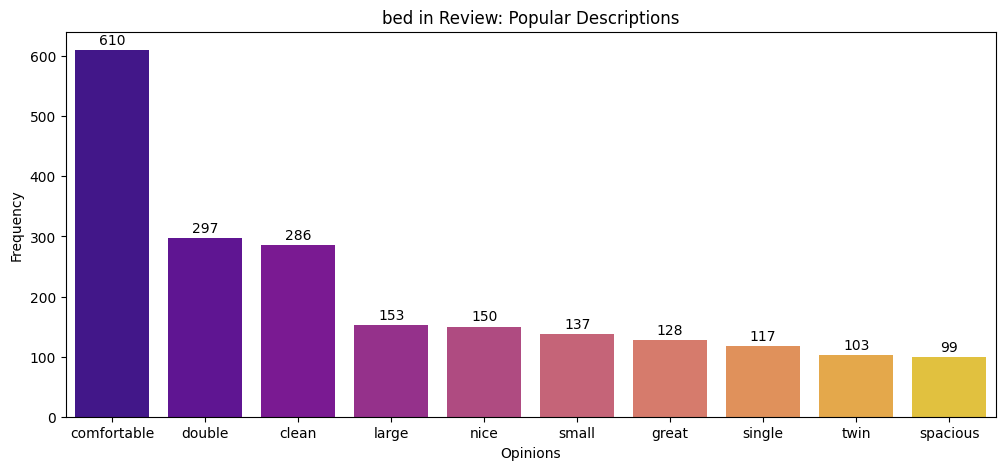

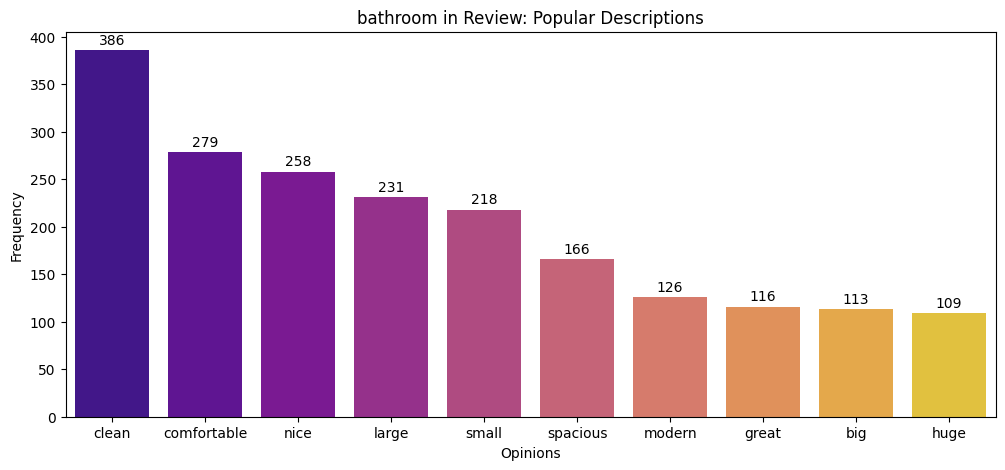

In [14]:
#extract sentiments and its count from the previous dictionary and  plot Top10 most discussed Aspects
for aspect in top_aspects['Aspect']:
    top_sentiments = aspect_sentiment_count[aspect]
    sentiment_list = list(top_sentiments.items())
    sentiment_list.sort(key = lambda x : x[1], reverse = True)
    top_10_sentiments = sentiment_list[:10]
    top_sents = pd.DataFrame(top_10_sentiments, columns = ['Sentiment', 'Count'])
    plt.figure(figsize = (12, 5))
    ax = sns.barplot(x = top_sents['Sentiment'], y = top_sents['Count'], palette = 'plasma')
    plt.xlabel("Opinions")
    plt.ylabel("Frequency")
    plt.title(f"{aspect} in Review: Popular Descriptions")
    for i in range(10):
        bars = ax.containers[i]
        ax.bar_label(bars, labels=[int(bar.get_height()) for bar in bars], fontsize=10, color='black', padding=2)
    plt.show()





**Insights:**

##### We see a breakdown of which words guests most often use to describe specific hotel aspects like room, staff, location, service, and others. For example, rooms are frequently described as clean, staff as friendly, and locations as great or central.

**It is useful in practice,**
##### as it helps hotel managers quickly see what guests care about most and how they describe their experience:
-	Spot strengths (e.g. “friendly staff”)
-	Identify areas to improve (e.g. if “small room” or “poor service” appear often)
-	Align marketing with what guests actually hype(e.g. “central location”, “comfortable beds”)
-   Easy to act on customer feedback without having to manually read every review.

##### We are going to identify and visualize the 10 most negative sentiments for each of the top aspects (e.g., room, service). It first filters the aspects, then uses the SentimentIntensityAnalyzer to detect negative words associated with each aspect.Highlighting the most common criticisms for each aspect

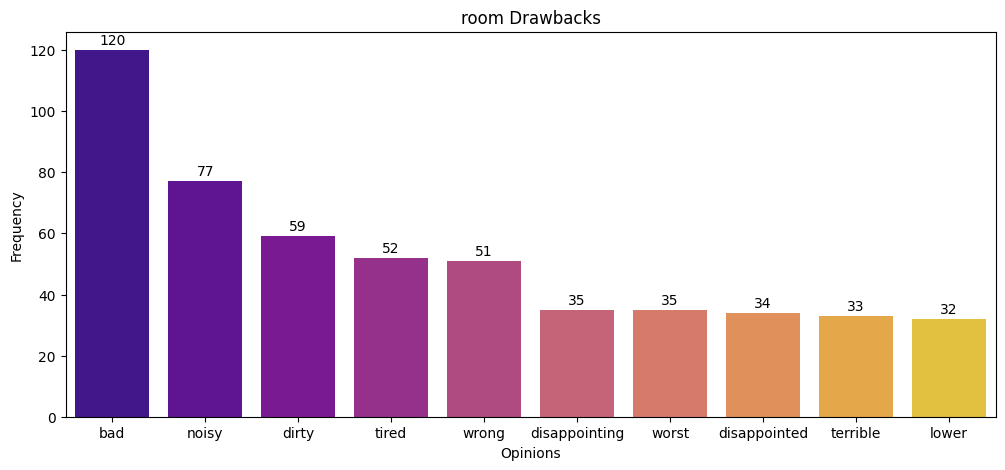

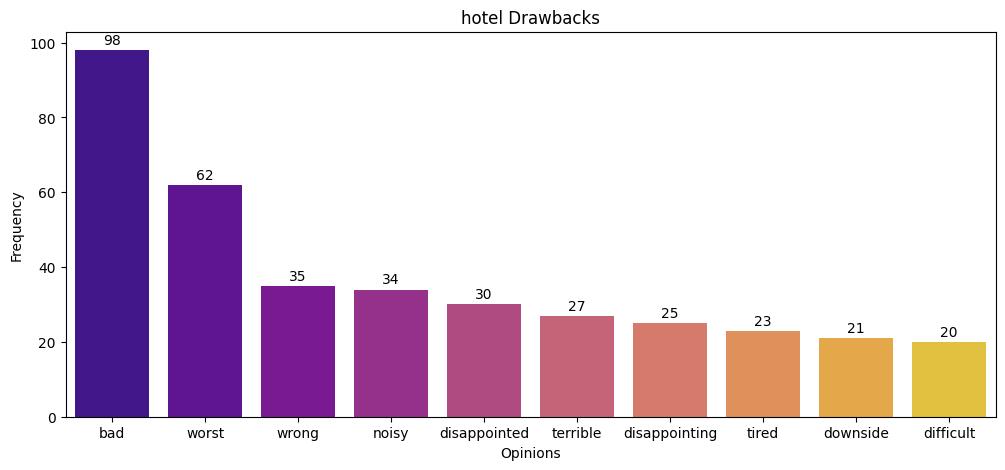

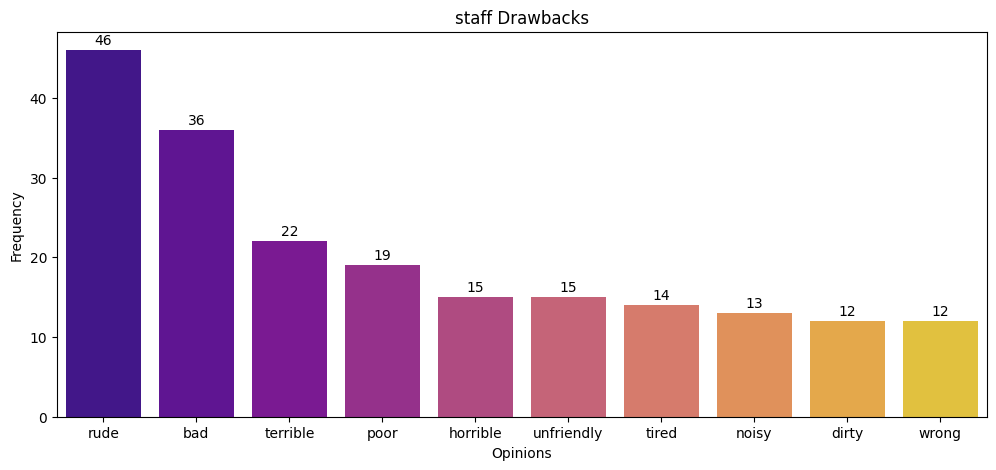

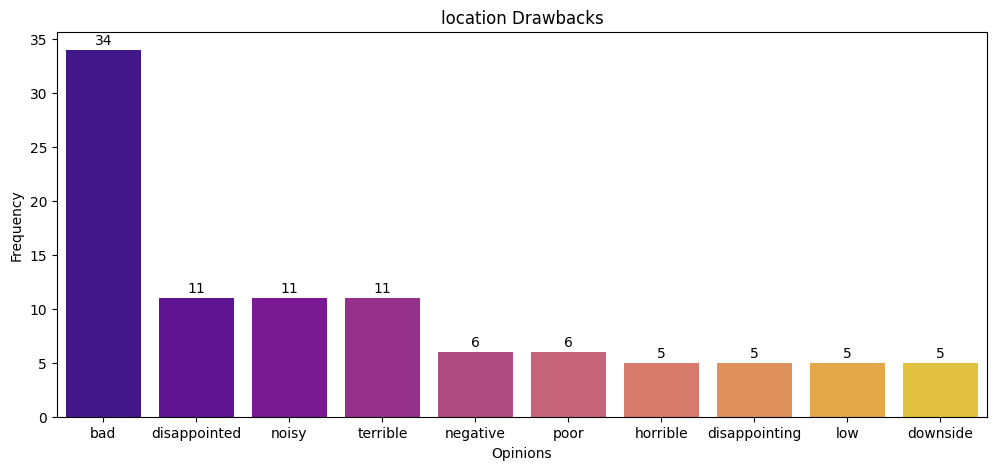

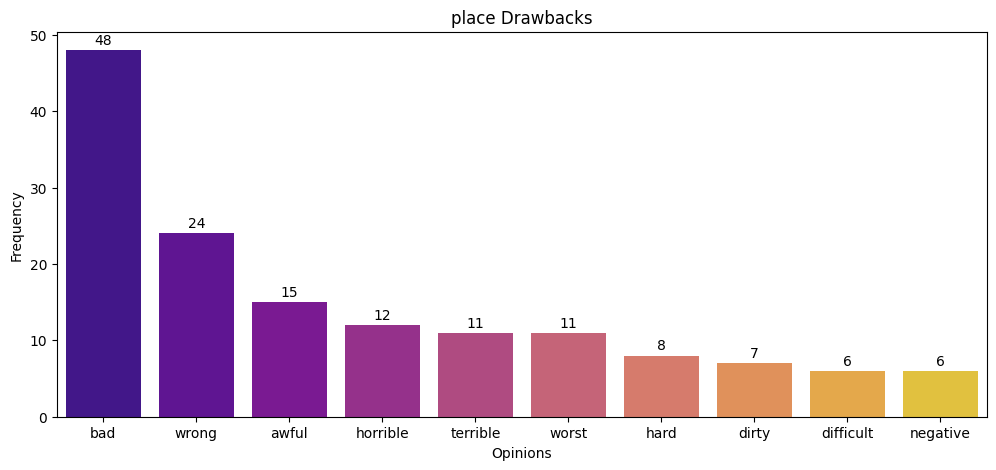

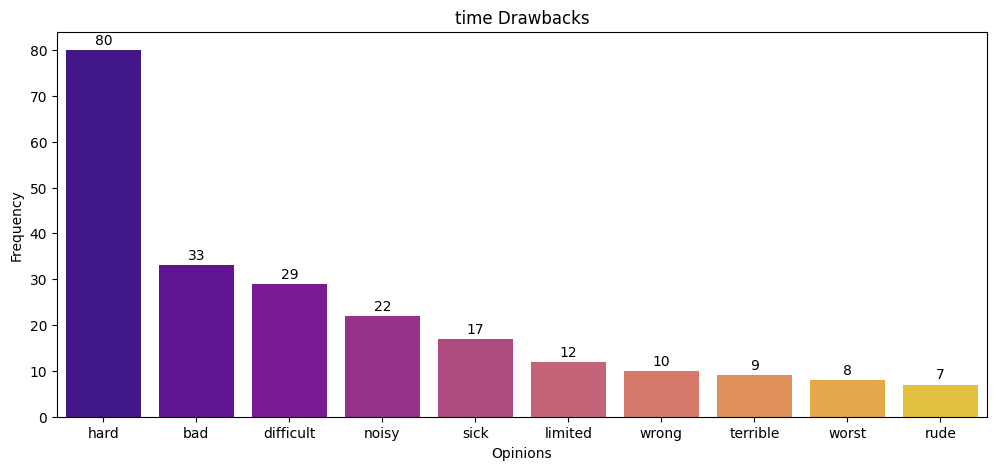

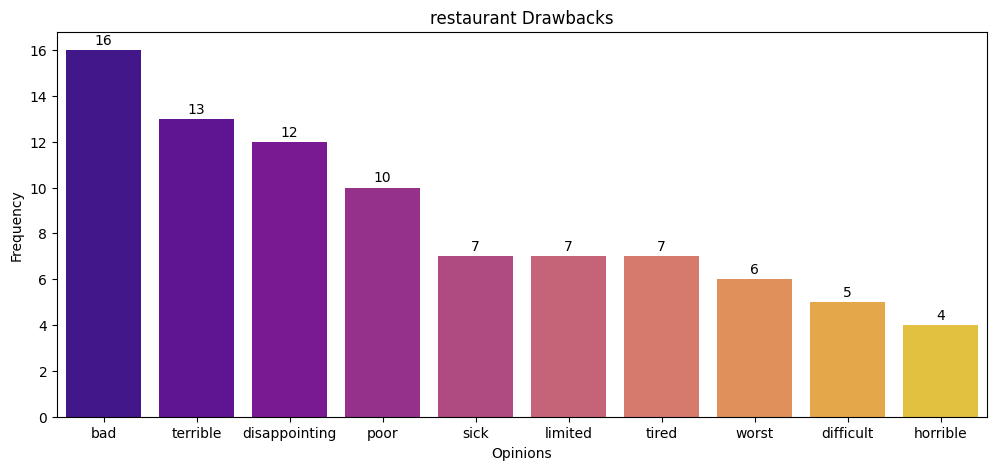

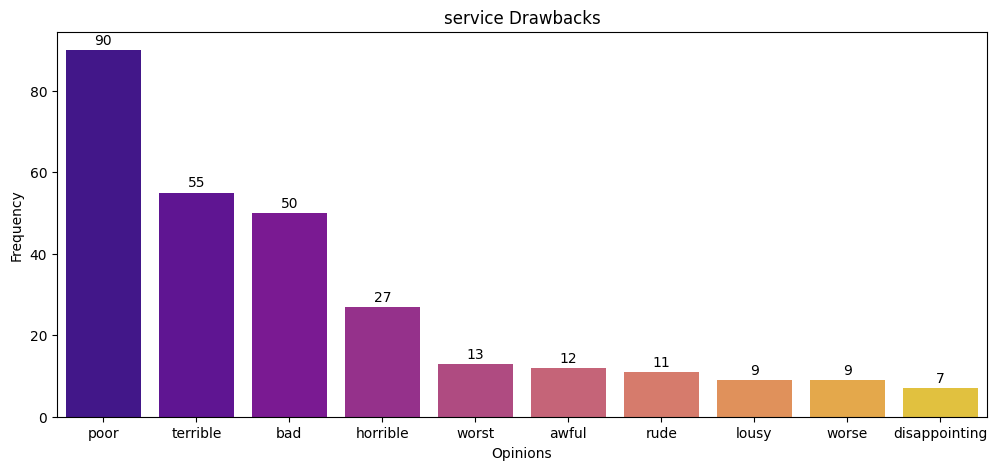

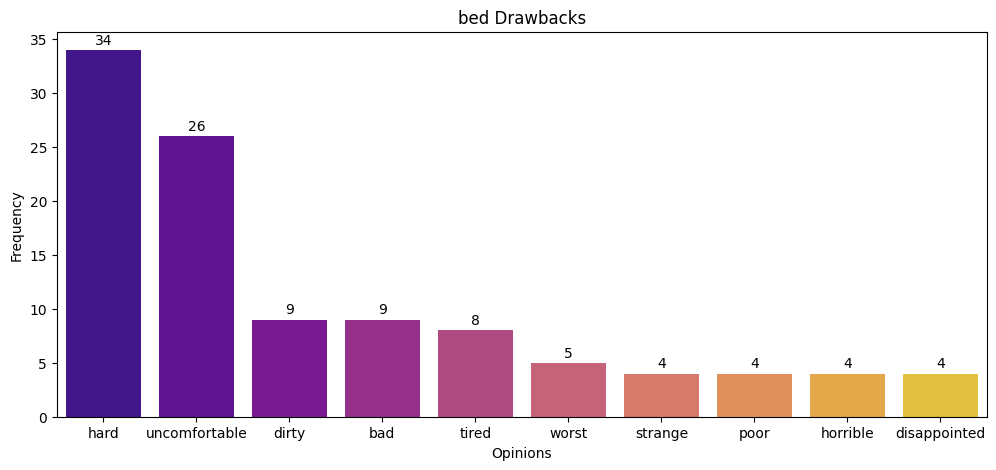

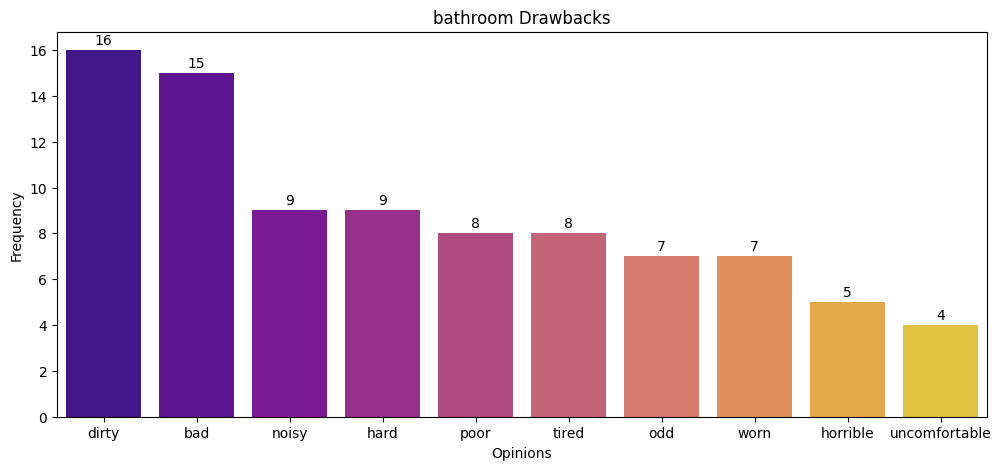

In [15]:
#find the 10 most negative sentiments for each top 10 Aspects and plot result
required_aspect = [aspect for aspect, count in top_10_aspects]
filtered_aspects = {aspect : sentiment for aspect, sentiment in aspect_sentiment.items() if aspect in required_aspect}
analyzer = SentimentIntensityAnalyzer()
aspect_negative_words = {}
for aspect, words in filtered_aspects.items():
    negative_words = []
    for word in words:
        score = analyzer.polarity_scores(word)
        if score['neg'] > 0:
            negative_words.append(word)
    top_negative = Counter(negative_words).most_common(10)
    aspect_negative_words[aspect] = top_negative

for aspect in required_aspect:
    plt.figure(figsize = (12, 5))
    sent_count = aspect_negative_words[aspect]
    df = pd.DataFrame(sent_count, columns = ['Sentiment', 'Count'])
    ax = sns.barplot(x = df['Sentiment'], y = df['Count'], palette = 'plasma')
    plt.xlabel("Opinions")
    plt.ylabel("Frequency")
    plt.title(f"{aspect} Drawbacks")
    for i in range(10):
        bars = ax.containers[i]
        ax.bar_label(bars, labels=[int(bar.get_height()) for bar in bars], fontsize=10, color='black', padding=2)
    plt.show()




**Insight:**
##### These charts show what exactly guests complain about most, like bad rooms, rude staff, or noisy locations. While star ratings give a general impression, this detailed breakdown reveals **why** guests were unhappy.

##### Its very useful in practice: hotel managers can quickly spot repeating issues and focus on what needs fixing first, based on real guest feedback.

Note:
In this project, we visualized the top ´ most mentioned aspects (like room, service, staff) and analyzed the most frequent negative opinions about them. This mirrors how a hotel might use the method in practice: by focusing on the aspects that guests talk about most and that matter most for service quality.

In daily service improvement scenarios, hotels may apply this kind of sentiment analysis only to the top negatively discussed aspects, to quickly identify what’s going generally wrong in the present period and act on.

##### We are going to identify the most "hated" aspects based on the negative sentiment words associated with each aspect. It uses the SentimentIntensityAnalyzer to detect negative words and counts how many negative words are linked to each aspect. 

In [16]:
#filter only the negative sentiments for each aspect and store it in the dictionary
analyzer2 = SentimentIntensityAnalyzer()
most_hated_aspect = {}
for aspect, sentiment in aspect_sentiment.items():
    negative_sentiment = []
    for word in sentiment:
        score2 = analyzer2.polarity_scores(word)
        if score2['neg'] > 0:
            negative_sentiment.append(word)
        top_neg = Counter(negative_sentiment)
        most_hated_aspect[aspect] = top_neg




In [17]:
#filter out the frequency of most hated aspects
negative_sentiment_count = Counter()
for aspect, sentiment in most_hated_aspect.items():
    negative_sentiment_count[aspect] = len(sentiment)

most_negative = negative_sentiment_count.most_common(10)
most_negative = pd.DataFrame(most_negative, columns = ['Aspect', 'Count'])
most_negative

,Aspect,Count
0,room,173
1,hotel,138
2,staff,110
3,bit,107
4,people,102
5,day,99
6,night,91
7,time,90
8,place,79
9,thing,76


##### This block visualizes the frequency of the most "hated" aspects (those with the highest number of negative words) using a bar chart. The chart shows which aspects are most commonly criticized in the reviews.

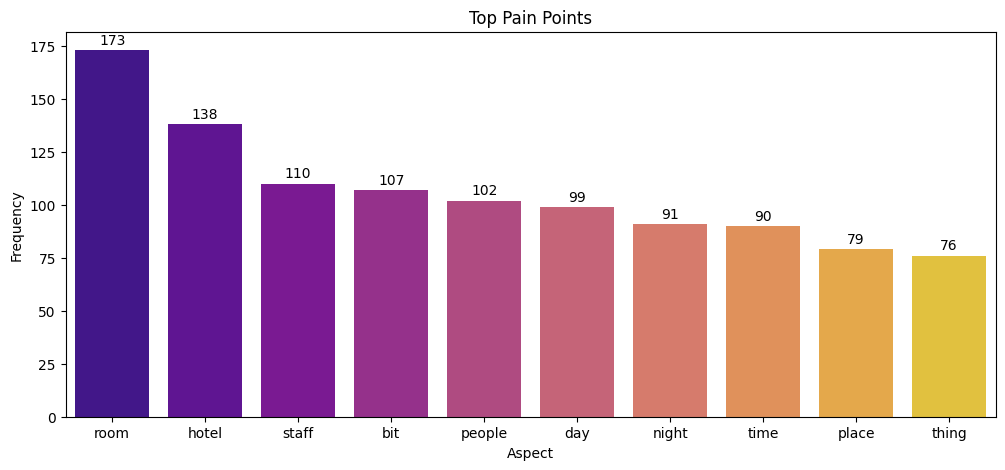

In [18]:
#plot the barplot of the frequency of most hated Sentiments
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = most_negative['Aspect'], y = most_negative['Count'], palette = 'plasma')
plt.xlabel("Aspect")
plt.ylabel("Frequency")
plt.title("Top Pain Points")
for i in range(10):
    bars = ax.containers[i]
    ax.bar_label(bars, labels=[int(bar.get_height()) for bar in bars], fontsize=10, color='black', padding=2)
plt.show()

**Insights:**

##### Insight: What guests complain about most(focusing on neagtive aspects)

##### We looked at which aspects of the hotel were mentioned most overall — and which ones were mentioned most in negative comments. Room, hotel, and staff came out on top in both cases. This means they’re not only important to guests, but also where most problems happen. On the other hand, location is often mentioned but rarely in a negative way — so it’s likely a strength. This helps hotel managers focus on the areas that really need attention to avoid negative feedback.

##### We are going to visualize the top 10 most common negative sentiments (criticisms) for each of the most "hated" aspects. Filtering out the negative sentiments for each aspect and sorting them by frequency.

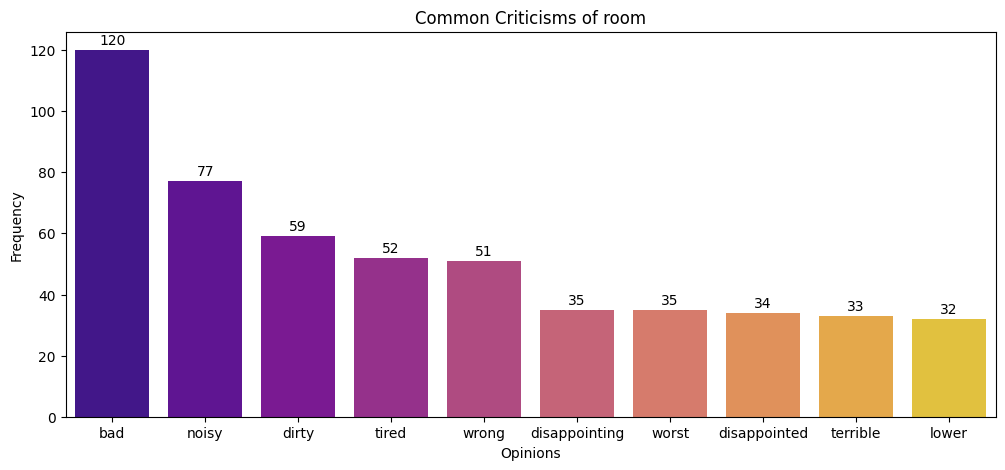

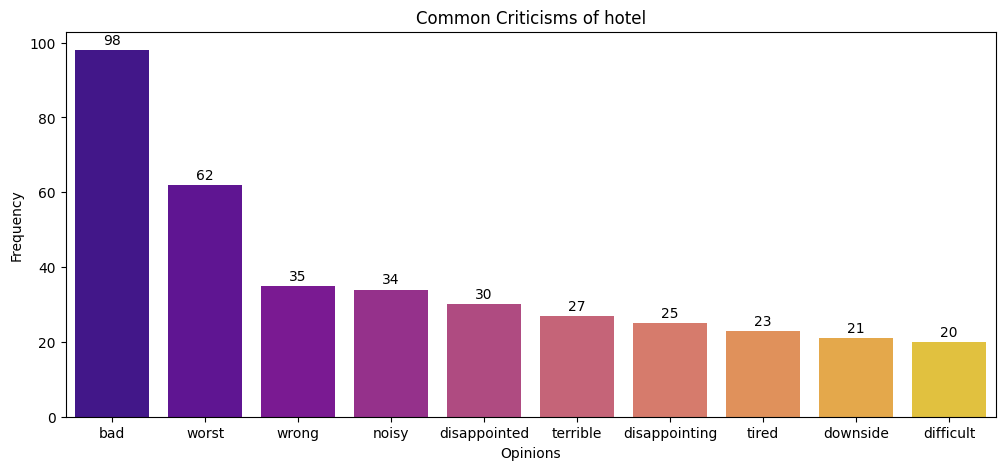

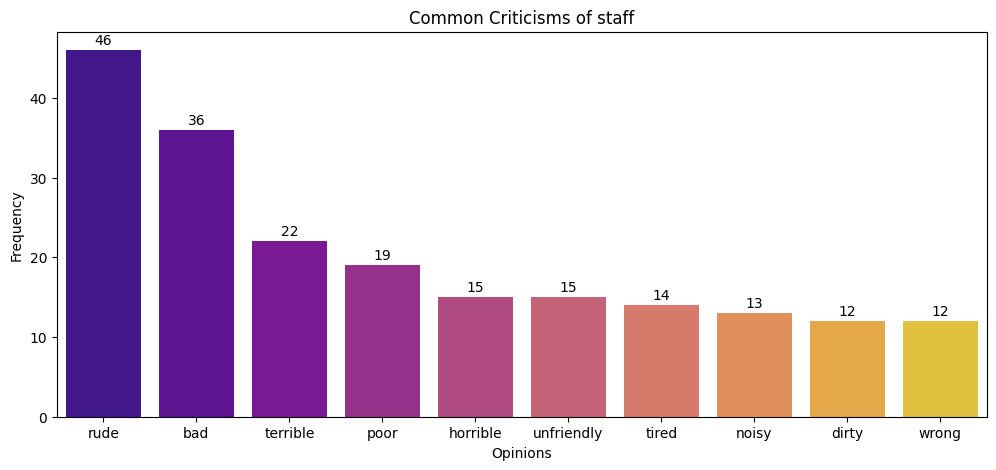

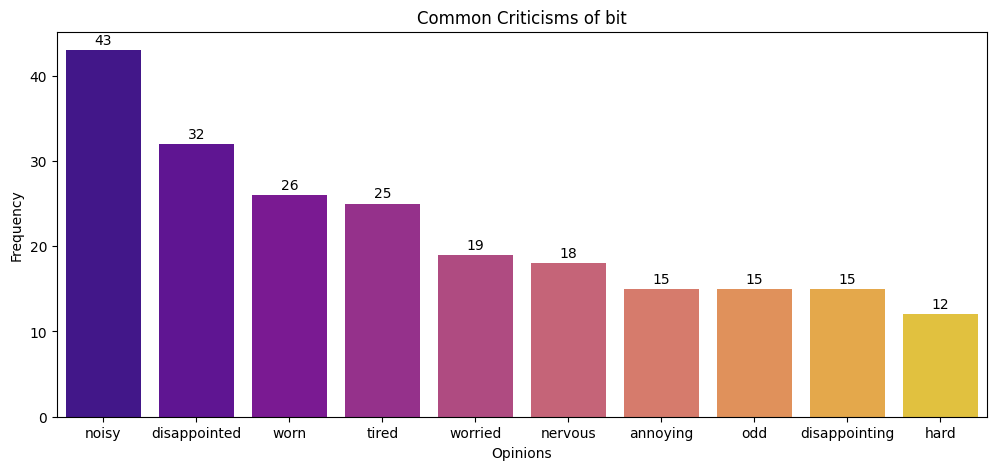

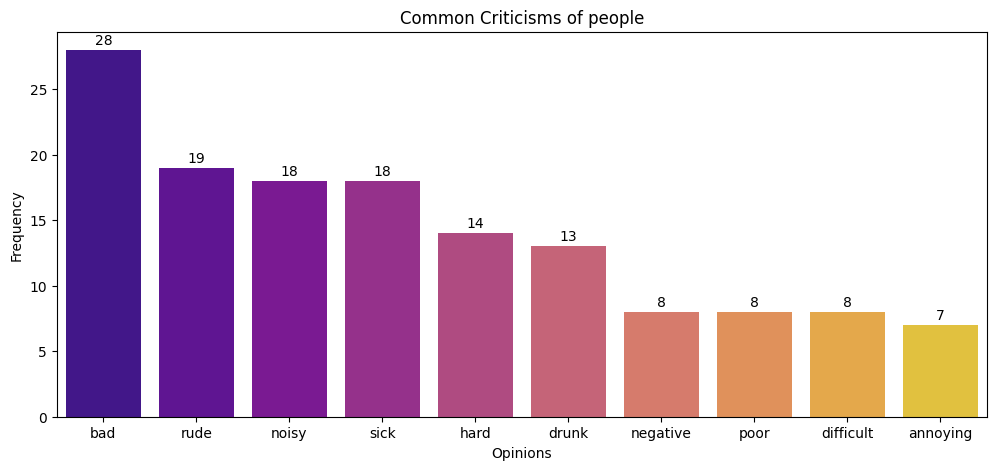

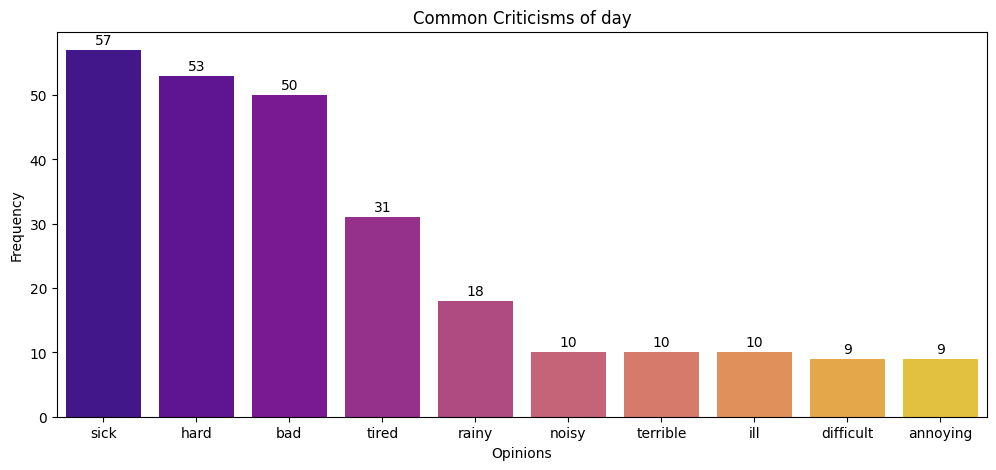

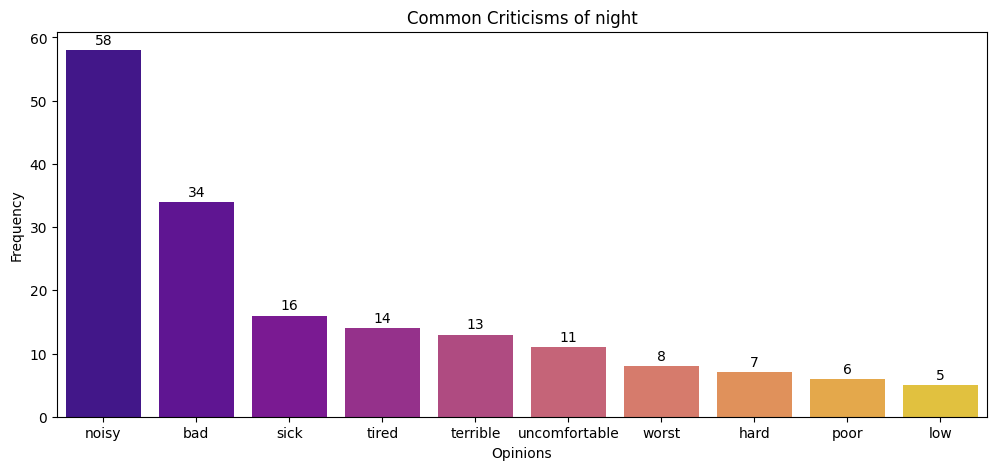

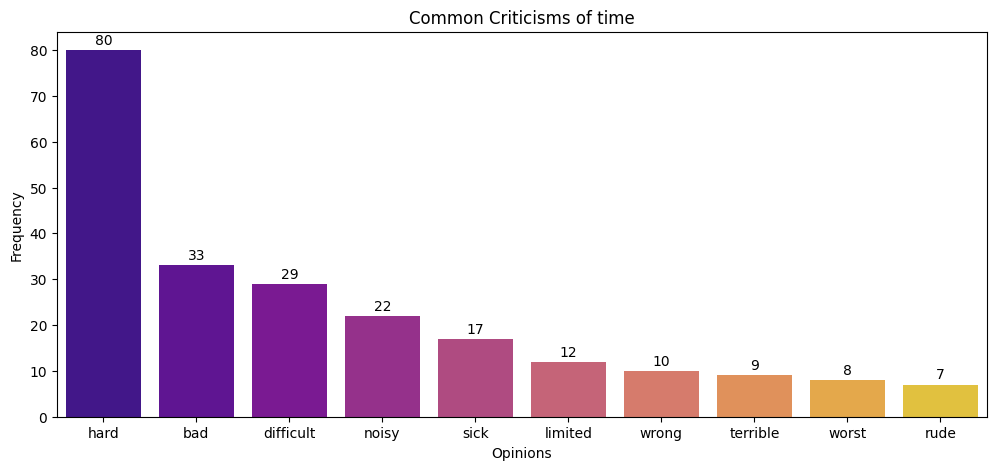

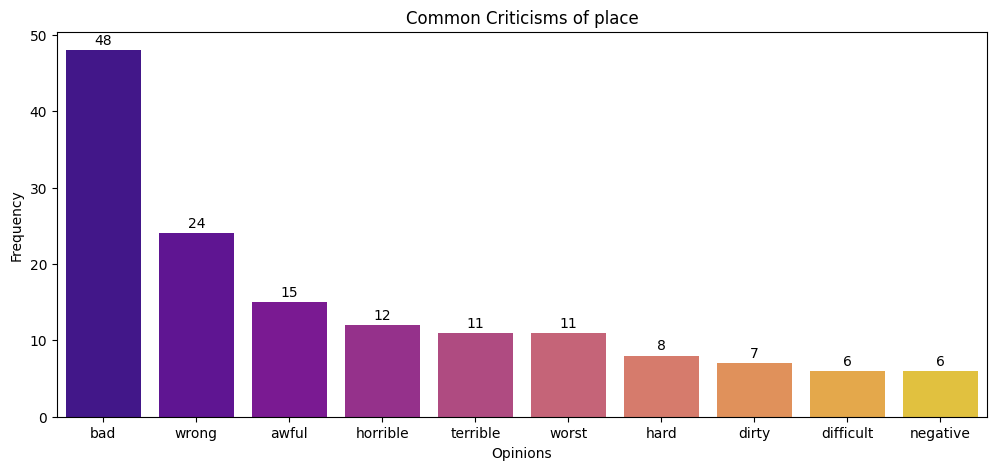

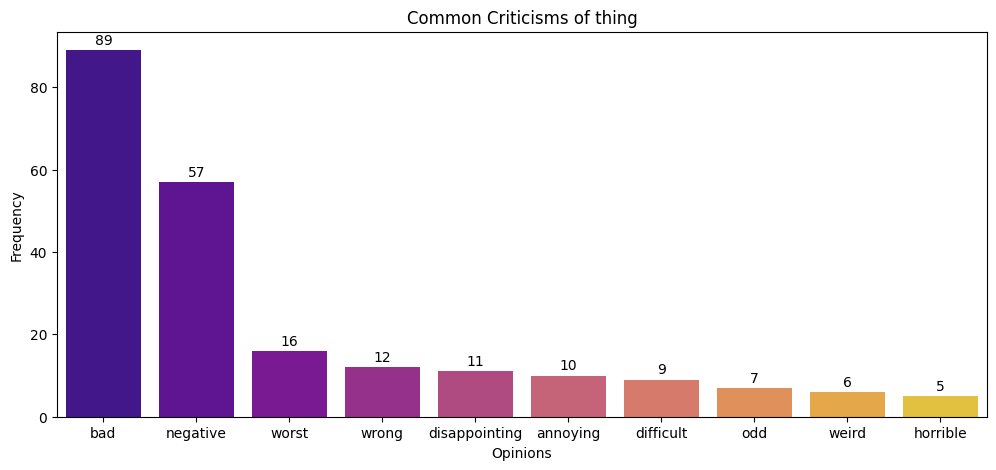

In [19]:
hated_aspects = list(most_negative['Aspect'])
hated_aspect_sentiment = {aspect : sentiment for aspect, sentiment in most_hated_aspect.items() if aspect in hated_aspects}
for aspect in hated_aspects:
    senti_count = most_hated_aspect[aspect]
    senti_list = list(senti_count.items())
    senti_list.sort(key = lambda x : x[1], reverse = True)
    most_hated_10 = senti_list[:10]
    most_hated_10 = pd.DataFrame(most_hated_10, columns = ['Sentiment', 'Count'])
    plt.figure(figsize = (12, 5))
    ax = sns.barplot(x = most_hated_10['Sentiment'], y = most_hated_10['Count'], palette = 'plasma')
    plt.title(f"Common Criticisms of {aspect}")
    plt.xlabel("Opinions")
    plt.ylabel("Frequency")
    for i in range(10):
        bars = ax.containers[i]
        ax.bar_label(bars, labels = [int(bar.get_height()) for bar in bars], fontsize=10, color='black', padding=2)
    plt.show()


**Insight:**
##### While aspects like “room” and “staff” are frequently mentioned overall, focusing only on negative comments reveals additional pain points such as “bit,” “people,” and “night.” This shows that some issues may be less talked about but still cause dissatisfaction, helping hotels uncover hidden problems and take more targeted action.

##### We are going to identify and count the most positive sentiments (words) associated with each aspect. It uses the SentimentIntensityAnalyzer to detect positive words and then counts how often each positive word appears for each aspect - **Top Loved Aspects**

In [20]:

analyzer = SentimentIntensityAnalyzer()

#count positive
aspect_positive_words = {}
for aspect, words in aspect_sentiment.items():
    positive_words = []
    for word in words:
        score = analyzer.polarity_scores(word)
        if score['pos'] > 0:
            positive_words.append(word)
    top_positive = Counter(positive_words).most_common(10)
    if top_positive:
        aspect_positive_words[aspect] = top_positive

##### We are going to calculate and visualize the total count of positive mentions for each aspect. It sums up the positive word counts for all aspects and identifies the top 10 aspects with the highest positive sentiment

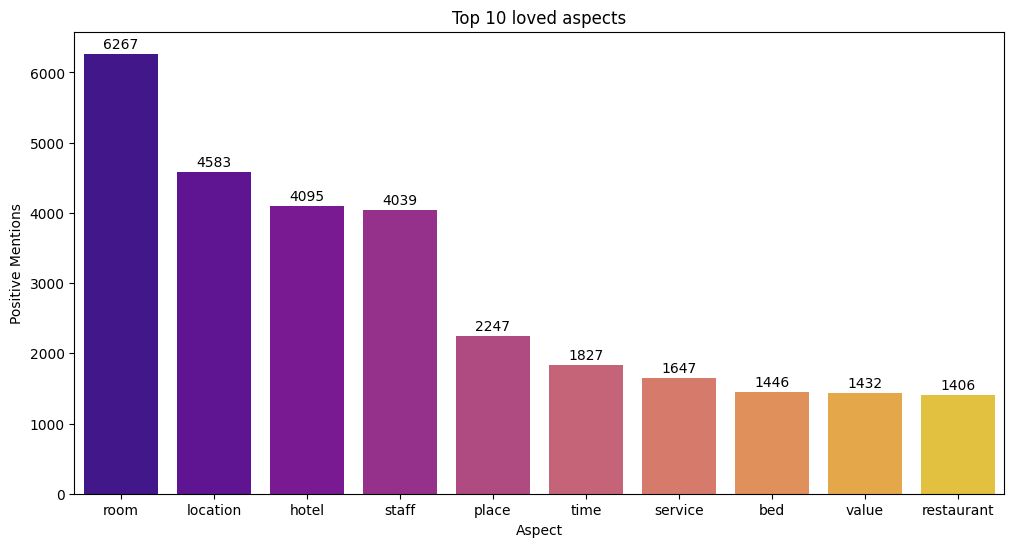

In [21]:
#total counts of positiv words per aspect
positive_counts = {aspect: sum(dict(words).values()) for aspect, words in aspect_positive_words.items()}
top_positive_aspects = Counter(positive_counts).most_common(10)

#get a  dataframe 
top_pos_df = pd.DataFrame(top_positive_aspects, columns=['Aspect', 'Count'])

#plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Aspect', y='Count', data=top_pos_df, palette='plasma')
plt.title("Top 10 loved aspects")
plt.xlabel("Aspect")
plt.ylabel("Positive Mentions")
for i in range(len(top_pos_df)):
    bars = ax.containers[i]
    ax.bar_label(bars, labels=[int(bar.get_height()) for bar in bars], fontsize=10, color='black', padding=2)
plt.show()

**Insights: Why also to analyze loved aspects?**

##### While overall aspect frequency shows what guests talk about most, it doesn’t not provide deeper insight about the top loved and top hated aspects. Our approach shows which aspects are praised vs criticized in general.

##### Top 10 overall aspects: Shows what guests mention most often. Gives a general idea of what matters to them (e.g. “room”, “location”, “staff”).
##### Top 10 “hated” aspects: Shows which aspects appear most frequently with negative words. Based on word co-occurrence (not per-sentence classification). Useful for spotting where guests complain the most.(to do improvements)
##### Top 10 “loved” aspects: Shows which aspects appear most frequently with positive words. Useful for spotting what guests praise the most. (marketing use)


Note:
In this project, we focused more deeply on the negative aspects to help identify key problem areas. While we also visualized the most loved aspects, we didn’t break down the positive descriptions in detail, also as we showed that alredy on the overall aspects. If necessary and the loved aspects would vary a lot from the overall aspects it would make sense to go deeper.

##### This block compares the positive and negative sentiment counts for each aspect by combining the sentiment data. It calculates the total number of positive and negative mentions for the aspects that have both positive and negative sentiments, then creates a bar chart to visualize the comparison 

**Visual comparison of postive vs negative aspects**

In [22]:
#store data combining sentiment counts (positive & negative) for each aspect 
aspect_comparison = []


common_aspects = set(aspect_positive_words.keys()) & set(aspect_negative_words.keys())

for aspect in common_aspects:
    pos = sum(dict(aspect_positive_words[aspect]).values())
    neg = sum(dict(aspect_negative_words[aspect]).values())
    aspect_comparison.append((aspect, pos, neg))

#create df
comparison_df = pd.DataFrame(aspect_comparison, columns=['Aspect', 'Positive', 'Negative'])
comparison_df = comparison_df.sort_values(by='Positive', ascending=False).head(10)

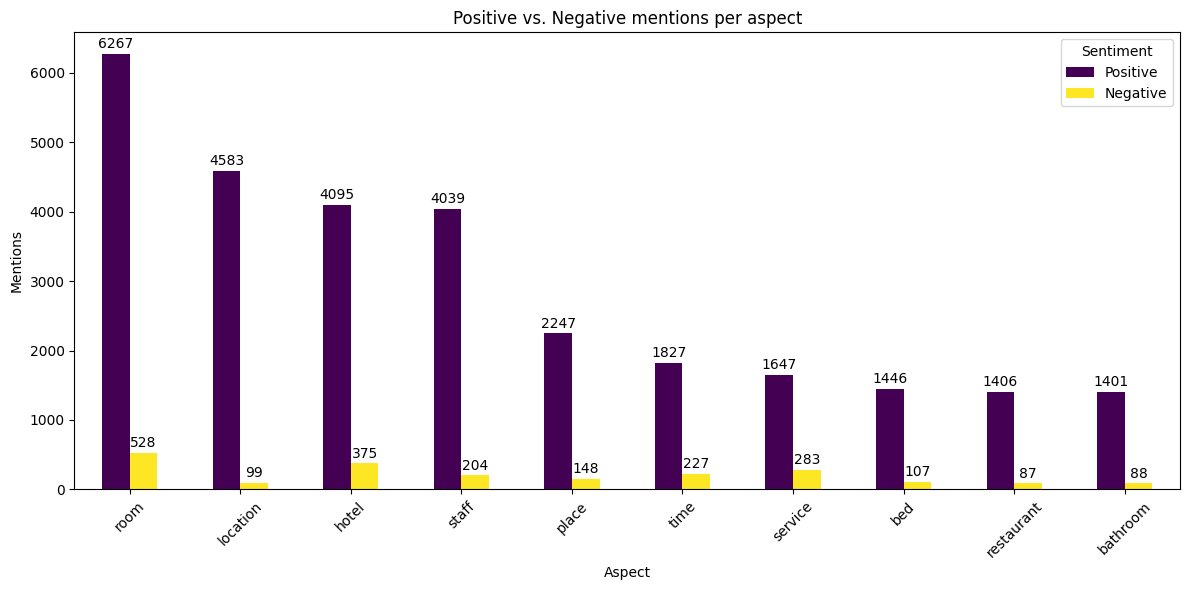

In [23]:
ax = comparison_df.set_index('Aspect')[['Positive', 'Negative']].plot(
    kind='bar', stacked=False, figsize=(12,6), colormap='viridis'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10, color='black', padding=2)
plt.title("Positive vs. Negative mentions per aspect")
plt.ylabel("Mentions")
plt.xlabel("Aspect")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


**Insights: Comparing positive vs. negative mentions per aspect**

##### This chart helps move beyond just knowing what guests talk about, it shows how they feel about each aspect. That makes it especially useful for hotel managers and/or service teams.

##### Key takeaways:
-	Room is mentioned most overall, but also receives many negative mentions.
This signals inconsistent quality and a high-impact area for improvement.
-	Staff shows a similar pattern: lots of praise, but also notable complaints.
It may indicate varying guest experiences depending on shift or person.
-	Location stands out as almost entirely positive.
This is a clear strength that can be emphasized in marketing.

##### In practice:
-	Hotels can focus improvement efforts on aspects with mixed feedback (like “room” or “staff”).
-	Top positive aspects can be used to highlight strengths in ads and booking platforms.
-	This dual view makes it easier to prioritize actions and track progress over time.

##### We are going to generate and display word clouds for the top 3 most loved aspects (room, location, and staff). It gathers all the positive words related to each aspect, based on the sentiment analysis results, and creates a word cloud where the most frequently mentioned words appear larger

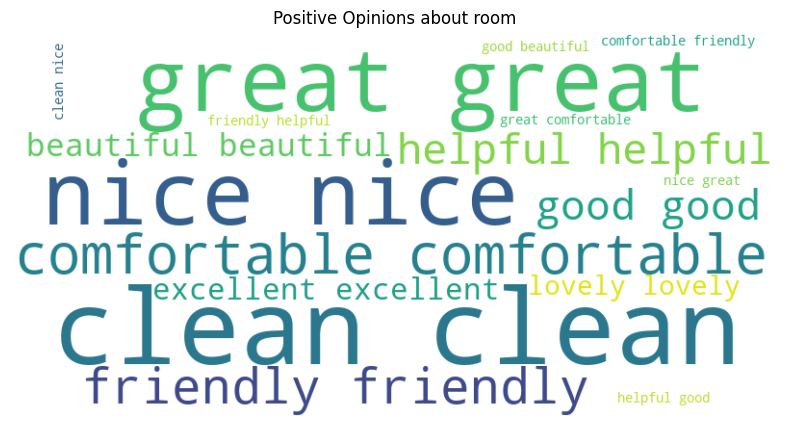

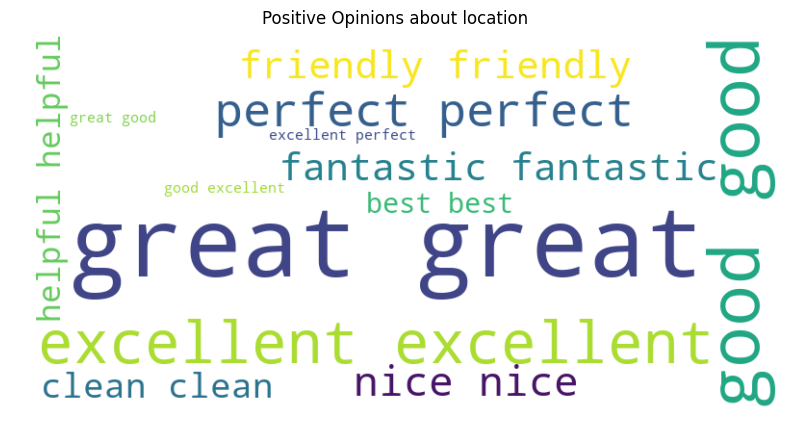

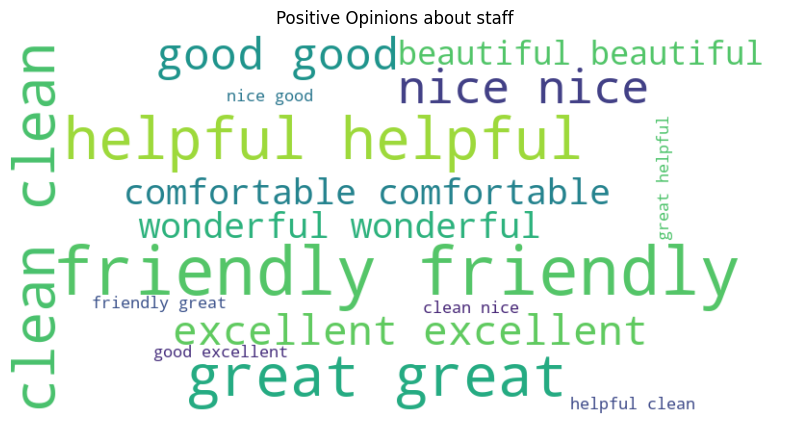

In [24]:
#Top 3 loved 
for aspect in ['room', 'location', 'staff']: 
    words = []
    #collect and repeat words based on their score
    for word, score in aspect_positive_words.get(aspect, []):
        words.extend([word] * score)
    #create wordcloud if any words
    if words:
        text = ' '.join(words)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Positive Opinions about {aspect}")
        plt.show()

##### We are going to identify negative words for each aspect (room, service, staff) and creates word clouds to visualize the most common negative sentiments. Only words with significant negative sentiment are considered

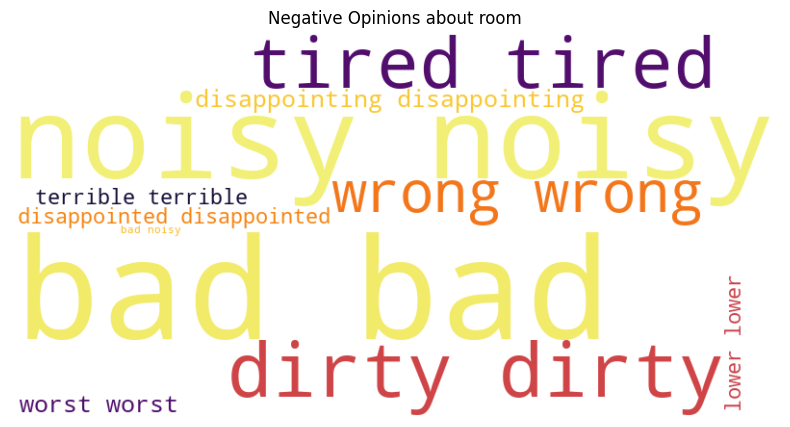

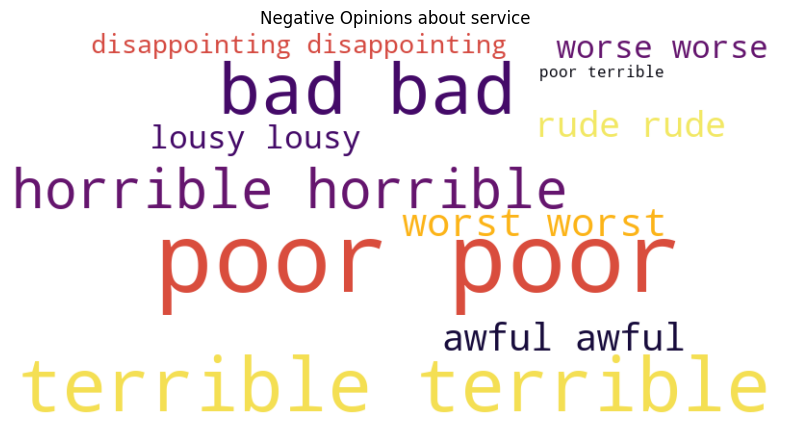

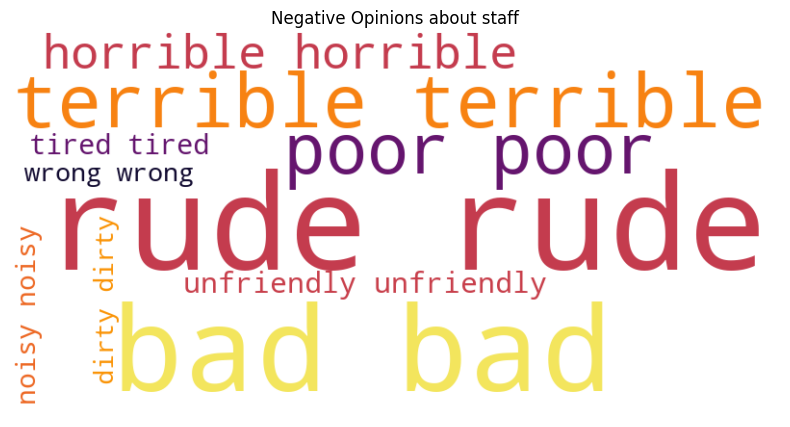

In [25]:
analyzer = SentimentIntensityAnalyzer()
#dictionary to store negative words
aspect_negative_bag = {}

#check each aspect word if neagtive
for aspect, words in filtered_aspects.items():
    negative_words = []#list to collect negative
    for word in words:
        # get sentiment scores using VADER
        score = analyzer.polarity_scores(word)
        #check if word has negative sentiment
        if score['neg'] > 0.01:  
            negative_words.append(word)
     #count the frequency of negative words       
    top_negative = Counter(negative_words).most_common(10)
    #store into dictionary
    aspect_negative_bag[aspect] = top_negative

#create Wordclouds  for key aspects
for aspect in ['room', 'service', 'staff']:
    words = []
    #check if aspect is present in the dictionary
    for word, score in aspect_negative_bag.get(aspect, []):
        words.extend([word] * score) 
    if words:
        text = ' '.join(words)
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Negative Opinions about {aspect}")
        plt.show()

**Insight:**
##### By visualizing the most common positive and negative words for the top 3 aspects, we gain quick and intuitive insight into what exactly guests like or dislike about the hotel. This helps hotel managers:
- Spot concrete issues (e.g., “dirty” rooms, “slow” service)
- Reinforce strengths (e.g., “clean” rooms, “helpful” staff)
- Communicate better in marketing or team briefings
##### It turns abstract sentiment into clear, actionable information.

## 3. [Modeling & Evaluation](#Modeling-&-Evaluation)

### **MACHINE LEARNING**

**Goal of the machine learning part**

##### The goal of the ML section is to automatically classify the overall sentiment of each review as positive, neutral, or negative.
##### This enables large volumes of text feedback to be processed quickly and consistently — especially useful when reviews don’t include star ratings or when businesses want to filter and respond based on tone.

##### By training and comparing different models (like Logistic Regression, SVC, and XGBoost), we aim to find the most accurate and reliable classifier for real-world use.


**ML Pipeline:**
Step1:

- We’re using the cleaned and preprocessed raw review text (Review) as input data X and the Sentiment column(mapped from ratings) as target y.
- We splitting off 20% to use only at very end, while we use the remaining 80% for our model development. This prevents data leakage overfitting and allows us to  simulate how our model performs in the real world on truly unseen data, and is adding credibility to our results.
- The remaining data is splitted into training and testing subsets to later evaluate how well the model performs on unseen data.
Means: Training 60% (X_train,y_train), Validation 20% (X_valid, y_valid), Final Test 20% (X-final, y_final)


In [26]:
#assigning full input and target columns
X_full = trip_advisor['Review']     #cleaned review text
y_full = trip_advisor['Sentiment']  #mapped sentiment lable

#set 20% of data as a final test set
X_main, X_final, y_main, y_final = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)




In [27]:
#splitting the remaining 80% into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_main, y_main, test_size=0.25, random_state=42, stratify=y_main
)


**ML Pipeline:**
Step2:

- Convert cleaned review text into numeric vectors for ML modelling. Setting with stopword removal, 5k features
- Fit and transform the training data only, to avoid data leakage(having real unseen data), amd transform validation and final test sets with the same fitted vectorizer.
Means: Sparse matrices can be used as input to ML models.

In [28]:
#create TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

#fitting vectorizer only on training data but transform all 3 splits
X_train_tfidf = vectorizer.fit_transform(X_train)     #learn + transform training
X_valid_tfidf = vectorizer.transform(X_valid)        
X_final_tfidf = vectorizer.transform(X_final)     

**ML Pipeline:**
Step3:

We are setting up 3 ML models:
- Logistic Regression: as this linear model is strong with high-dimensional data like our text.
- Naive Bayes: as it is based on probabilities and commonly used for sentiment(spam) classification.
- Random Forest: As ensemble of decision trees it is good with nonlinear patterns on hughe data.

Using:
X_train_tfidf as cleaned, vectorized review text.
y_train as sentiment labels.

In [29]:
#ML models using their basic parameters
log_reg = LogisticRegression(max_iter=1000)
nb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [30]:
#training  models 
log_reg.fit(X_train_tfidf, y_train)
nb.fit(X_train_tfidf, y_train)
rf.fit(X_train_tfidf, y_train);

**ML Pipeline:**
Step4:
- Make model predicitons.
- Generate classification report to do comparison on accuracy, precision, recall.

In [31]:
#logistic Rregression
logistic_predictions = log_reg.predict(X_valid_tfidf)
print("\nLogistic Regression")
print(classification_report(y_valid, logistic_predictions))




Logistic Regression
              precision    recall  f1-score   support

    negative       0.82      0.76      0.79       643
     neutral       0.57      0.18      0.27       437
    positive       0.88      0.98      0.93      3018

    accuracy                           0.86      4098
   macro avg       0.75      0.64      0.66      4098
weighted avg       0.84      0.86      0.84      4098



In [32]:
#naive bayes
nb_predictions = nb.predict(X_valid_tfidf)
print("\nNaive Bayes")
print(classification_report(y_valid, nb_predictions))


Naive Bayes
              precision    recall  f1-score   support

    negative       0.88      0.58      0.69       643
     neutral       0.00      0.00      0.00       437
    positive       0.82      1.00      0.90      3018

    accuracy                           0.82      4098
   macro avg       0.57      0.52      0.53      4098
weighted avg       0.74      0.82      0.77      4098



In [33]:
#random forest
rf_predictions = rf.predict(X_valid_tfidf)
print("\nRandom Forest")
print(classification_report(y_valid, rf_predictions))


Random Forest
              precision    recall  f1-score   support

    negative       0.88      0.49      0.63       643
     neutral       1.00      0.00      0.01       437
    positive       0.81      1.00      0.89      3018

    accuracy                           0.81      4098
   macro avg       0.89      0.50      0.51      4098
weighted avg       0.84      0.81      0.76      4098



**ML Pipline:**

**Model Evaluation:**


| Metric              | Logistic Regression | Naive Bayes | Random Forest |
|---------------------|---------------------|-------------|----------------|
| Accuracy            | 0.86                | 0.82        | 0.81           |
| Neutral Recall      | 0.18                | 0.00        | 0.00           |
| Positive Recall     | 0.98                | 1.00        | 1.00           |
| Negative Recall     | 0.75                | 0.58        | 0.49           |
| F1-score (neutral)  | 0.27                | 0.00        | 0.01           |


Note: Accuracy may be misleading as our data is imbalanced due to positiv reviews

##### Logistic Regression:
Highest overall accuracy 0.86.
Good performance on positive and negative.
Captures some neutral but still missing most.

##### Naive Bayes:
Strong on positive, moderate on negative.
Fails on neutral completely.

##### Random Forest:
Fails on neutral.
Weaker on negative.

##### Means: 
Our dataset is imbalanced, the models just guess “positive” or “negative” and skip “neutral”.
For us in the service industry a strong recall on the negative is essential!



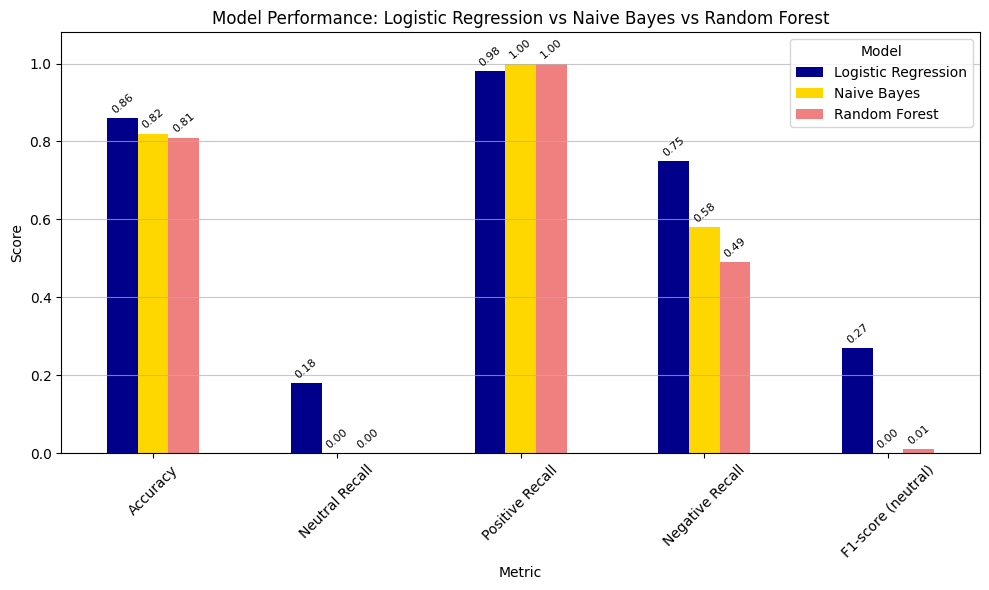

In [34]:
#define metrics / scores for each model
metrics = ["Accuracy", "Neutral Recall", "Positive Recall", "Negative Recall", "F1-score (neutral)"]
log_reg = [0.86, 0.18, 0.98, 0.75, 0.27]
naive_bayes = [0.82, 0.00, 1.00, 0.58, 0.00]
random_forest = [0.81, 0.00, 1.00, 0.49, 0.01]

#get a dataframe for plotting
df = pd.DataFrame({
    "Metric": metrics,
    "Logistic Regression": log_reg,
    "Naive Bayes": naive_bayes,
    "Random Forest": random_forest
})

#plot grouped bar plot
ax = df.set_index('Metric').plot(
    kind='bar',
    figsize=(10, 6),
    color=['darkblue', 'gold', 'lightcoral'], 
    rot=45,
    title='Model Performance: Logistic Regression vs Naive Bayes vs Random Forest'
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8, color='black', padding=2, rotation = 40)
plt.ylabel('Score')
plt.ylim(0, 1.08)
plt.grid(axis='y', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


**Confusion Matrix:**

##### We further show also the confusion matrix to visualise how well our model predicts each sentiment label:
##### Logistic Regression: High diagonal values assume good predictions.
##### Naive Bayes: Ignores neutral.
##### Random Forest: Strong on positive and weak elsewhere.

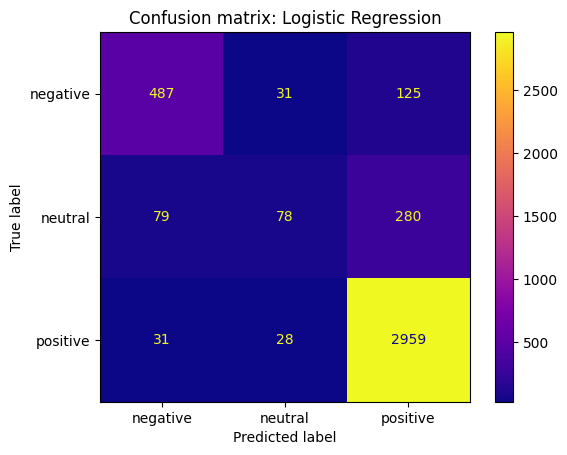

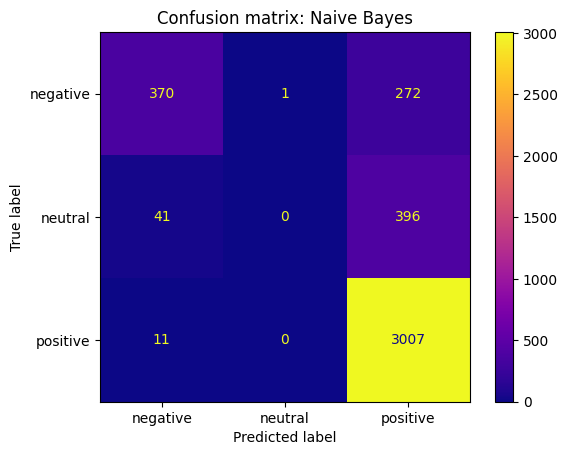

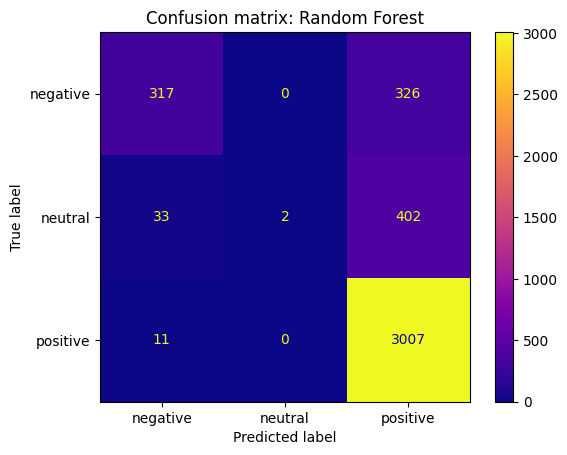

In [35]:
#use dicitonary to define names
models = {
    "Logistic Regression": logistic_predictions,
    "Naive Bayes": nb_predictions,
    "Random Forest": rf_predictions
}

#plot confusion matrices 
for model_name, predictions in models.items():
    cm = confusion_matrix(y_valid, predictions, labels=["negative", "neutral", "positive"])
    disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "neutral", "positive"])
    
    disp.plot(cmap="plasma", values_format='d')
    plt.title(f"Confusion matrix: {model_name}")
    plt.grid(False)
    plt.show()

**Model choice / Conclusion:**

##### As we have already seen our dataset is imbalanced — the vast majority of reviews are positive. As a result, most machine learning models tend to predict “positive” by default and largely skip over the “neutral” class. This leads to very low recall for neutral feedback and a potential under-detection of negative sentiment.

##### In the service industry, however, a strong recall on negative reviews is essential, as these contain valuable signals for service improvement and customer retention.

##### Reducing the setiment classes might seem an obvious solution as simplifying the sentiment into just “positive” and “negative” might improve model performance but it would eliminate the nuance of neutral feedback.
##### The neutral feedback often include helpful suggestions rather than complaints.
##### It can have a signalling function of problems before customers become fully unhappy. So we should keep them.

##### This given we start now with retrain Logistic Regression, as this was the top performing model so far, with class balancing (class_weight='balanced').

##### So we may reduce the dominance of the positive class and improve detection of neutral and negative sentiment not just predict positiv by default. Without the balancing, the model focuses too much on the dominant class (“positive”) and fails to detect important neutral or negative feedback.

##### After it we might go on with Hyperparameter Tuning with GridSearchCV.

**Retrain + Evaluation of Logistic Regression with class_weight='balanced'**

##### We are retraining our Logistic Regression model using the parameter class_weight='balanced'. This tells the model to automatically adjust the importance (weight) of each sentiment class based on how often it appears in the training data.

##### By using class_weight='balanced', we give more importance to underrepresented classes during training, which can help the model:
##### - Better detect negative reviews
##### - Improve neutral recall
##### - Reduce bias toward the positive class

In [36]:
#fit Logistic Regression with class_weight='balanced'
log_reg_balanced = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg_balanced.fit(X_train_tfidf, y_train)

#predict on the validation set
balanced_predictions = log_reg_balanced.predict(X_valid_tfidf)

#evaluate performance
print("Logistic Regression (Balanced Class Weights)\n")
print(classification_report(y_valid, balanced_predictions, digits=2))



Logistic Regression (Balanced Class Weights)

              precision    recall  f1-score   support

    negative       0.72      0.80      0.76       643
     neutral       0.35      0.51      0.41       437
    positive       0.95      0.86      0.91      3018

    accuracy                           0.82      4098
   macro avg       0.67      0.72      0.69      4098
weighted avg       0.85      0.82      0.83      4098



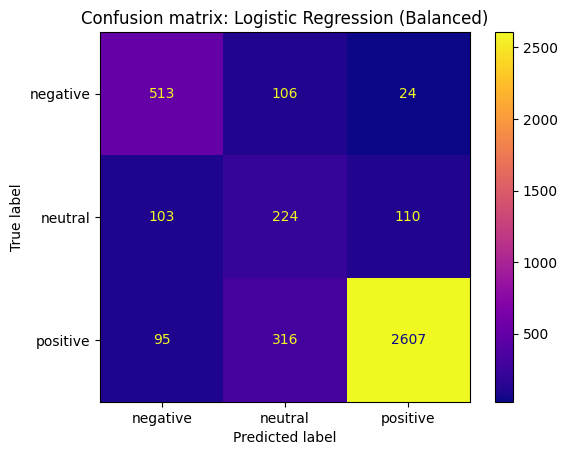

In [37]:


#plot confusion matrix
cm = confusion_matrix(y_valid, balanced_predictions, labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="plasma", values_format='d')
plt.title("Confusion matrix: Logistic Regression (Balanced)")
plt.grid(False)
plt.show()

**Evaluation of Logistic Regression (Balanced):**

##### By applying class_weight='balanced', the model shows a significantly better ability to detect neutral and negative reviews compared to the original version.


##### - Negative recall improved to 0.80 (from ~0.75), which is important for identifying service issues!

##### - Although: Neutral recall increased to 0.51, showing that the model now recognizes many more neutral reviews — which were previously missed.

##### - Positive recall slightly decreased to 0.86, but still has high precision.


##### The overall balance across all three classes improved!
##### The macro F1-score rose to 0.69, indicating more consistent performance across all sentiments.

**Conclusion:**
##### Again as in the hospitality context identifying dissatisfaction/areas for improvement is a priority, we have a valuable model improvment!

##### We have now a more business-relevant and fair classification, especially for service quality monitoring.

##### The model may now work well for real use cases in the hotel or service industry.


**Model Tuning:**

##### To improve our Logistic Regression model, we are using GridSearchCV to automatically tests different model settings (hyperparameters).

##### We tune the regularization strength (C), which controls how much the model tries to avoid overfitting.

In [38]:
#parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'class_weight': ['balanced']
}

#get GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1), 
                           param_grid, 
                           scoring='f1_macro', 
                           cv=3,
                           n_jobs=-1)

#fit training data
grid_search.fit(X_train_tfidf, y_train)

#find best model
best_log_reg = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)



Best parameters: {'C': 1, 'class_weight': 'balanced'}


**GridSearch Results:**

##### The results from GridSearch tuning are the same as before. So the default C=1 was already optimal for our setup.

##### It confirms that our manually configured model is already tuned effectively, no further improvement needed.

**Model Selection Summary (Logistic Regression):**

##### After testing multiple machine learning models (Naive Bayes, Random Forest, and Logistic Regression), we selected Logistic Regression with class weighting as the final model.

##### This model gave the best results overall. It was especially good at finding neutral and negative reviews, which are very important in the service industry.

##### Using class_weight='balanced' significantly improved recall for neutral and negative reviews — the two most underrepresented yet service-critical sentiment classes.

##### We also used GridSearchCV to check if we could improve the model by changing settings — but we found that our original setup was already the best.

##### Other models like SVM or XGBoost might give slightly better results, but they are harder to understand and slower to run as they have higher complexity and lower interpretability. For our project, we want a model that works well, is easy to explain, and can help spot unhappy customers early.


**Overall, our model is accurate, interpretable, and effective at catching early signs of dissatisfaction — making it a strong fit for real-world applications in hospitality and customer service monitoring.**

##### This model may help hospitality and service companies:
##### - Detect negative or neutral reviews early
##### - Understand what aspects need improvement (e.g. staff, cleanliness)
##### - Improve customer satisfaction and retention by acting on feedback

**Predict on the final test set -TRUE UNSEEN data**

##### We are using our trained and tuned Logistic Regression model to make predictions on the unseen test data (never used during training or tuning), X_final_tfidf, to get a a true simulation of how the model would perform in real life.

In [39]:
#predict on final test set
final_predictions = log_reg_balanced.predict(X_final_tfidf)

print("evaluation on unseen test set:\n")
print(classification_report(y_final, final_predictions, digits=2))



evaluation on unseen test set:

              precision    recall  f1-score   support

    negative       0.72      0.79      0.75       643
     neutral       0.33      0.49      0.39       437
    positive       0.95      0.86      0.90      3019

    accuracy                           0.81      4099
   macro avg       0.66      0.71      0.68      4099
weighted avg       0.84      0.81      0.82      4099



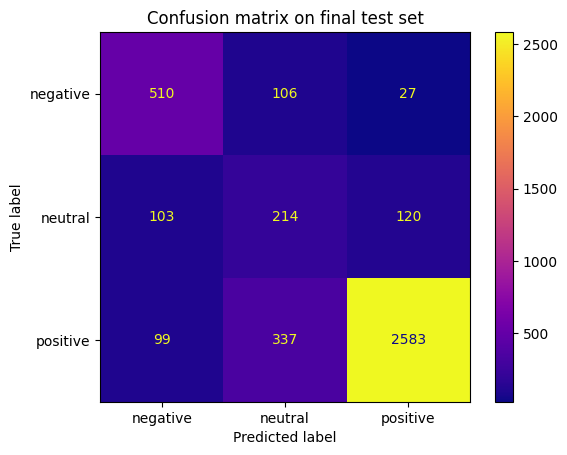

In [40]:
#plot confusion matrix
cm = confusion_matrix(y_final, final_predictions, labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="plasma", values_format='d')
plt.title("Confusion matrix on final test set")
plt.grid(False)
plt.show()

In [41]:
#comparison of validation and final test metrics
#define the metrics
metrics = ['Accuracy', 'Negative Recall', 'Neutral Recall', 'Positive Recall', 'Macro F1-score']
validation_scores = [0.81, 0.80, 0.51, 0.86, 0.69]
final_test_scores = [0.81, 0.79, 0.48, 0.85, 0.68]

#create a dataframe to compare
comparison_df = pd.DataFrame({
    'Metric': metrics,
    'Validation Set': validation_scores,
    'Final Test Set': final_test_scores
})

print(comparison_df)

            Metric  Validation Set  Final Test Set
0         Accuracy            0.81            0.81
1  Negative Recall            0.80            0.79
2   Neutral Recall            0.51            0.48
3  Positive Recall            0.86            0.85
4   Macro F1-score            0.69            0.68


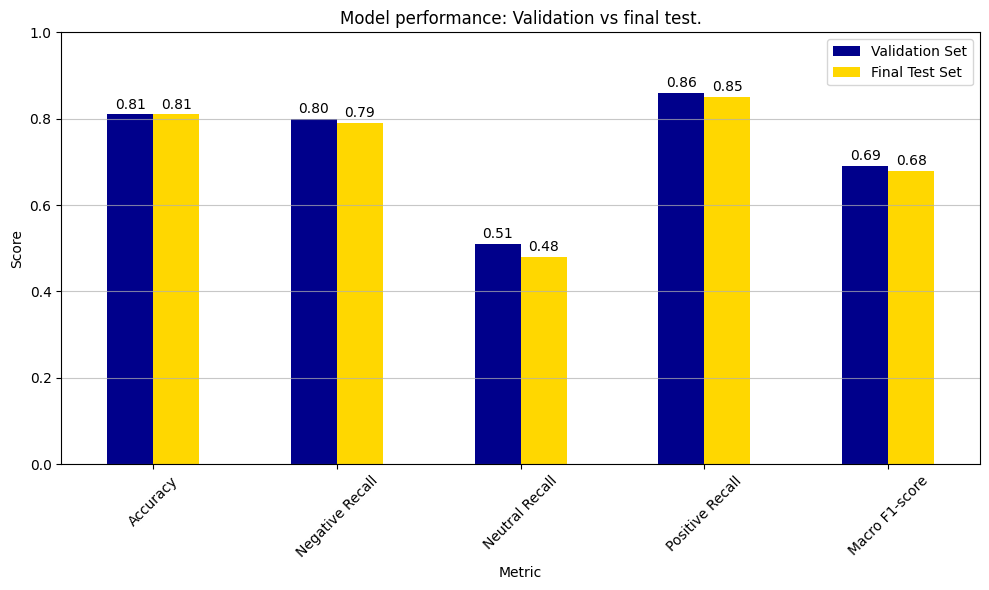

In [42]:
#plot group bar plot
ax = comparison_df.set_index('Metric').plot(
    kind='bar',
    figsize=(10, 6),
    color=['darkblue', 'gold'],
    rot=45,
    title='Model performance: Validation vs final test.'
    )
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f', fontsize=10, color='black', padding=2)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()


**Conclusion after testing on the unseen data:**

**The metrics in this final comparison plot clearly show that our Logistic Regression model with balanced class weights generalizes well to unseen data.** The validation and final test scores are almost similar across all key metrics.

##### To point out:

Neutral Recall:
Validation Set: 0.51
Final Test Set: 0.48

##### Even though neutral reviews are rare, our model still finds almost half of them — a big improvement compared to earlier models where neutral recall was near zero.

Negative Recall:
Validation Set: 0.80
Final Test Set: 0.79

##### The model reliably catches negative reviews, which is critical in the service industry for identifying unhappy customers early.

**All in all:**

##### - The model performs consistently on unseen data, no signs of overfitting.
##### - Most importantly for the hospitality industry, the recall for negative and neutral reviews remains strong.
##### - The model is robust and ready for practical use (e.g. real-time review monitoring).



**Exploring Further Models**

##### Even though our logistic regression model performs well, we explored additional models to validate and potentially improve our results, especially for the harder_to_detect neutral and negative reviews.

**LinearSVC**

##### The Linear Support Vector Classifier tries to find the best boundary to separate different classes. (also with many features, like our vectorized (former text) data). It can work well with imbalanced data, especially when tuned. It may improve classification of harder cases and is still fast and interpretable.

##### Since Linear SVC focuses on maximizing the margin between classes, it can be better at separating text data where the differences are small or subtle. This makes it especially useful for identifying neutral reviews, which often contain a mix of both positive and negative expressions. Unlike logistic regression, which tries to predict probabilities, SVC aims to find the most clear-cut boundary — helping it better handle borderline or unclear cases.


Classification Report LinearSVC (Balanced)
              precision    recall  f1-score   support

    negative       0.73      0.77      0.75       643
     neutral       0.37      0.35      0.36       437
    positive       0.92      0.92      0.92      3018

    accuracy                           0.84      4098
   macro avg       0.67      0.68      0.68      4098
weighted avg       0.83      0.84      0.84      4098



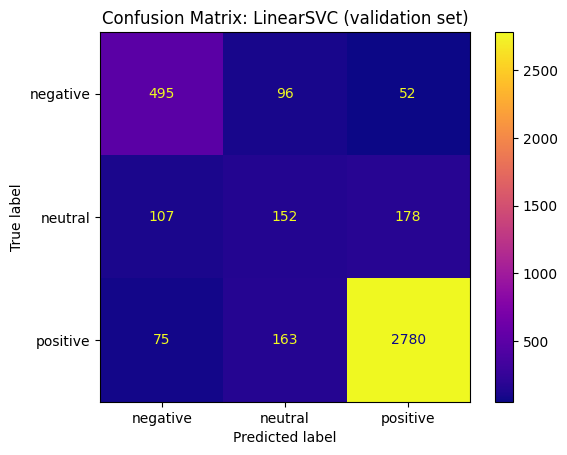

In [43]:

#set up model with class balancing
svc = LinearSVC(class_weight='balanced', random_state=42)

#fit(training data)
svc.fit(X_train_tfidf, y_train)

#predict(validation data)
svc_predictions = svc.predict(X_valid_tfidf)

#evalute performance
print("Classification Report LinearSVC (Balanced)")
print(classification_report(y_valid, svc_predictions, digits=2))

#plot confusionmatrix
cm = confusion_matrix(y_valid, svc_predictions, labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

disp.plot(cmap="plasma", values_format='d')

plt.title("Confusion Matrix: LinearSVC (validation set)")
plt.grid(False)
plt.show()

**Model Tuning LinearSVC(f1_macro)**

Best C: 0.1
              precision    recall  f1-score   support

    negative       0.75      0.81      0.78       643
     neutral       0.43      0.32      0.37       437
    positive       0.92      0.94      0.93      3018

    accuracy                           0.85      4098
   macro avg       0.70      0.69      0.69      4098
weighted avg       0.84      0.85      0.85      4098



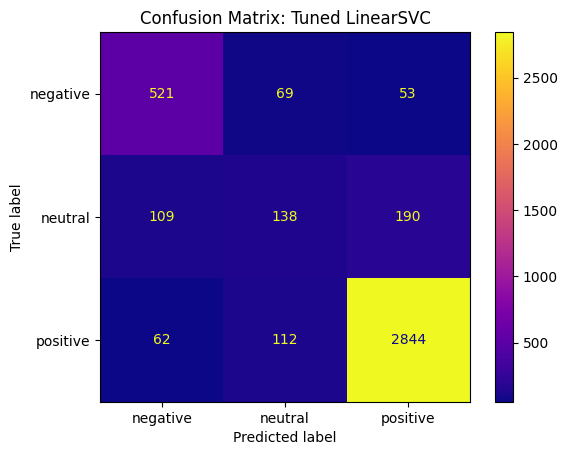

In [44]:

#set parameter grid for C_values to tune/test
param_grid = {
    'C': [0.01, 0.1, 1, 10]
}

#GridSearchCV: optimizing macro F1 score
gridsvc = GridSearchCV(svc, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)

#fit(training data)
gridsvc.fit(X_train_tfidf, y_train)

#find best model
best_svc = gridsvc.best_estimator_

#predict(validation data)
svc_pred = best_svc.predict(X_valid_tfidf)

#evaluate performance
print("Best C:", gridsvc.best_params_['C'])
print(classification_report(y_valid, svc_pred, digits=2))

# 8. Show confusion matrix
cm = confusion_matrix(y_valid, svc_pred, labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

disp.plot(cmap="plasma", values_format='d')

plt.title("Confusion Matrix: Tuned LinearSVC")
plt.grid(False)
plt.show()

##### We tuned our LinearSVC model using GridSearchCV, optimizing for the macro F1 score to ensure balanced performance across all three classes (positive, neutral, negative). This helped us improve overall fairness, especially for the underrepresented neutral class.

##### The following comparison shows how tuning slightly improved accuracy and negative recall, while the neutral recall slightly dropped — showing a trade-off in performance.

In [45]:
#set comparison data for LinearSVC and tuned version
svc_comparison_data = {
    "Metric": ["Accuracy", "Negative Recall", "Neutral Recall", "Positive Recall", "Macro F1-score"],
    "LinearSVC (Balanced)": [0.84, 0.77, 0.35, 0.92, 0.68],
    "Tuned LinearSVC (C=0.1)": [0.85, 0.81, 0.32, 0.94, 0.69]
}

svc_comparison_df = pd.DataFrame(svc_comparison_data)

print("Model comparison: LinearSVC (Balanced) vs. Tuned")
display(svc_comparison_df)

Model comparison: LinearSVC (Balanced) vs. Tuned


,Metric,LinearSVC (Balanced),Tuned LinearSVC (C=0.1)
0,Accuracy,0.84,0.85
1,Negative Recall,0.77,0.81
2,Neutral Recall,0.35,0.32
3,Positive Recall,0.92,0.94
4,Macro F1-score,0.68,0.69


**Side by side comparison LinearSVC and Losgistic Regression**

In [46]:

#set comparison data
data = {
    "Metric": ["Accuracy", "Negative Recall", "Neutral Recall", "Positive Recall", "Macro F1-score"],
    "Logistic Regression (Balanced)": [0.81, 0.80, 0.51, 0.86, 0.69],
    "Tuned LinearSVC": [0.85, 0.81, 0.32, 0.94, 0.69]
}

LSVC_LR_comparison_df = pd.DataFrame(data)

print("Model comparison")
display(LSVC_LR_comparison_df)

Model comparison


,Metric,Logistic Regression (Balanced),Tuned LinearSVC
0,Accuracy,0.81,0.85
1,Negative Recall,0.80,0.81
2,Neutral Recall,0.51,0.32
3,Positive Recall,0.86,0.94
4,Macro F1-score,0.69,0.69


**Interpretation:**

##### - LinearSVC is stronger overall in accuracy and positive class.
##### - Logistic Regression handles the neutral class better — which may be crucial as we are focused on service insights.
##### - Macro F1 is equal, both  balance the 3 classes similarly in average.

**All in all:**
##### Logistic Regression is better as we value balanced sentiment insight, especially wit respect to the neutral recall.

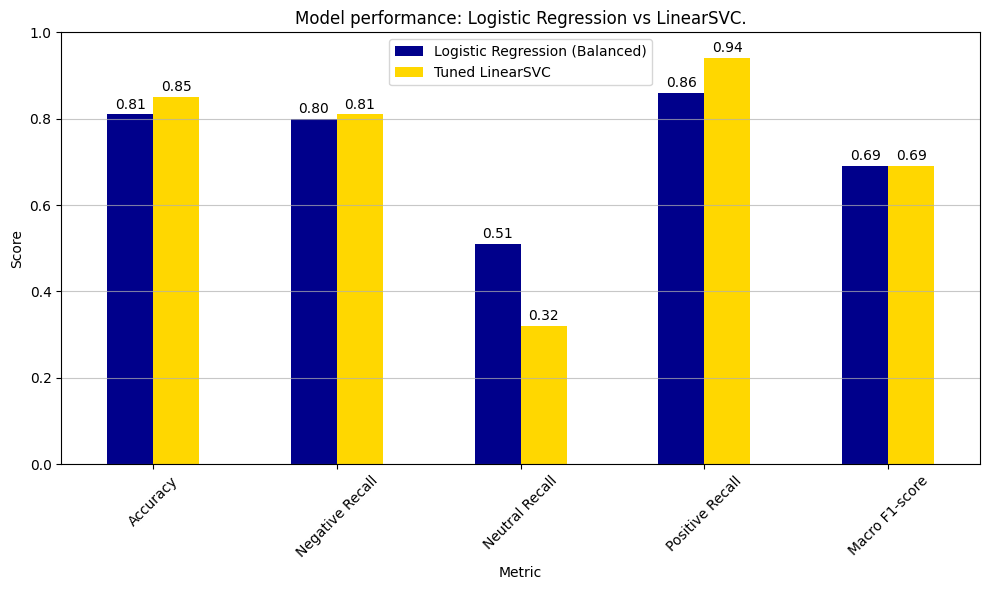

In [47]:
#plot group bar plot
ax = LSVC_LR_comparison_df.set_index('Metric').plot(
    kind='bar',
    figsize=(10, 6),
    color=['darkblue', 'gold'],
    rot=45,
    title='Model performance: Logistic Regression vs LinearSVC.'
    )
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f', fontsize=10, color='black', padding=2)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()

**SVC with RBF kernel**

##### Although our logistic regression model already performs well, we tested the SVC with an RBF kernel to explore whether a more flexible, non-linear model could detect more subtle patterns in the reviews. This step helps us confirm whether our simpler model is truly the best choice — or if a more complex model offers any noticeable gains. In the end, this ensures our model choice is not just good, but well justified.

##### The RBF (Radial Basis Function) kernel is more flexible than the linear version because it can capture non-linear patterns in the data.

##### We try it to see if this flexibility helps us to have a model which better understands subtle and complex language used in hotel reviews, especially in neutral or borderline cases.

##### We are aware that this may not be efficient, that it’s slower and harder to interpret, but it may improve performance if relationship between text and sentiment is not purely linear.

##### So we test it here as an add on!

Classification Report: SVC with RBF Kernel (Balanced)
              precision    recall  f1-score   support

    negative       0.75      0.80      0.77       643
     neutral       0.44      0.32      0.37       437
    positive       0.92      0.94      0.93      3018

    accuracy                           0.85      4098
   macro avg       0.70      0.69      0.69      4098
weighted avg       0.84      0.85      0.85      4098



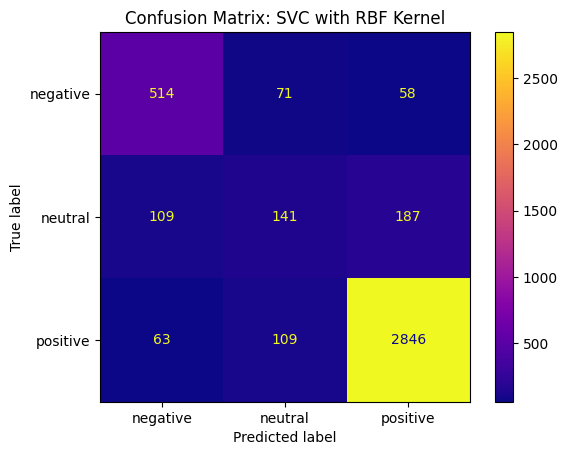

In [48]:


#train SVC with RBF kernel
svc_rbf = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svc_rbf.fit(X_train_tfidf, y_train)

#predict
svc_rbf_preds = svc_rbf.predict(X_valid_tfidf)


print("Classification Report: SVC with RBF Kernel (Balanced)")
print(classification_report(y_valid, svc_rbf_preds, digits=2))

#get confusion matrix
cm_rbf = confusion_matrix(y_valid, svc_rbf_preds, labels=["negative", "neutral", "positive"])
disp_rbf = ConfusionMatrixDisplay(confusion_matrix=cm_rbf, display_labels=["negative", "neutral", "positive"])
disp_rbf.plot(cmap="plasma", values_format='d')

plt.title("Confusion Matrix: SVC with RBF Kernel")
plt.grid(False)
plt.show()

##### The results of the RBF SVC model are very similar to those of the linear models.

**Tuning**

##### We do a basic hyperparameter tuning (adjusting C and gamma) to give the RBF model a fair chance to optimize its performance without making the comparison biased.

Fitting 3 folds for each of 9 candidates, totalling 27 fits


Best Parameters: {'C': 1, 'gamma': 'scale'}
              precision    recall  f1-score   support

    negative       0.75      0.80      0.77       643
     neutral       0.44      0.32      0.37       437
    positive       0.92      0.94      0.93      3018

    accuracy                           0.85      4098
   macro avg       0.70      0.69      0.69      4098
weighted avg       0.84      0.85      0.85      4098



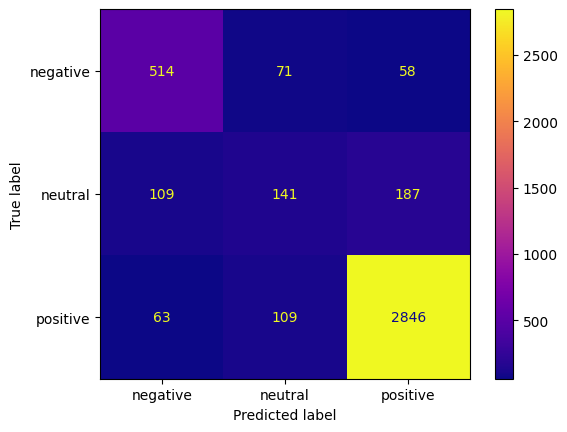

In [49]:


#define hyperparameter
param_grid_rbf = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001]
}

#GridSearch (optimize macro F1)
grid_rbf = GridSearchCV(svc_rbf, param_grid_rbf, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)

#fit 
grid_rbf.fit(X_train_tfidf, y_train)

#get best model
best_rbf = grid_rbf.best_estimator_

#predict 
rbf_preds = best_rbf.predict(X_valid_tfidf)


print("Best Parameters:", grid_rbf.best_params_)
print(classification_report(y_valid, rbf_preds, digits=2))

# Confusion Matrix
cm = confusion_matrix(y_valid, rbf_preds, labels=["negative", "neutral", "positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="plasma", values_format='d')

In [50]:

#set comparison data
data = {
    "Metric": ["Accuracy", "Negative Recall", "Neutral Recall", "Positive Recall", "Macro F1-score"],
    "Logistic Regression (Balanced)": [0.81, 0.80, 0.51, 0.86, 0.69],
    "Tuned LinearSVC": [0.85, 0.81, 0.32, 0.94, 0.69],
    "Tuned SVC (RBF Kernel)": [0.85, 0.80, 0.32, 0.94, 0.69]
}

comparison_df = pd.DataFrame(data)
print("Final Model Comparison")
display(comparison_df)

Final Model Comparison


,Metric,Logistic Regression (Balanced),Tuned LinearSVC,Tuned SVC (RBF Kernel)
0,Accuracy,0.81,0.85,0.85
1,Negative Recall,0.80,0.81,0.80
2,Neutral Recall,0.51,0.32,0.32
3,Positive Recall,0.86,0.94,0.94
4,Macro F1-score,0.69,0.69,0.69


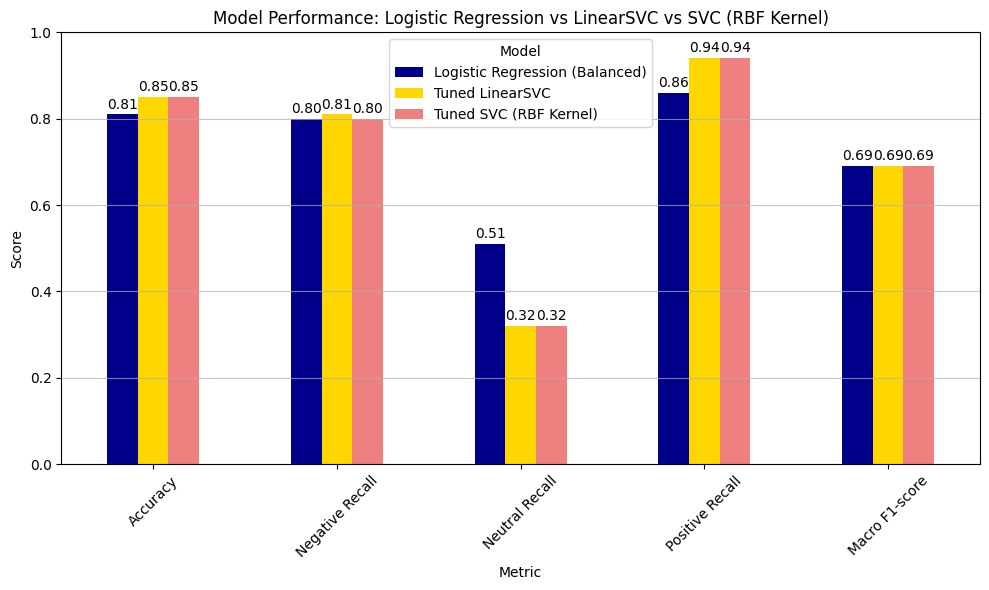

In [51]:

#plot grouped bar plot
ax = comparison_df.set_index('Metric').plot(
    kind='bar',
    figsize=(10, 6),
    color=['darkblue', 'gold', 'lightcoral'], 
    rot=45,
    title='Model Performance: Logistic Regression vs LinearSVC vs SVC (RBF Kernel)'
)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f', fontsize=10, color='black', padding=2)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

**Comparison result:**

##### After tuning, the SVC with RBF kernel showed similar performance to the tuned LinearSVC and Logistic Regression models, confirming that more complex modeling does not bring a significant advantage for this task.

##### This shows that, for our dataset, simpler linear models already capture the important patterns very well.

**XGBoost**

##### After testing linear models (Logistic Regression, SVC) and tree-based models (Random Forest), we additionally evaluated XGBoost.

##### XGBoost is a powerful tree-based model that can capture more complex, non-linear relationships in data.

##### Although we founf already a linear model, testing XGBoost helps to ensure that no hidden patterns were overlooked and to validate that simpler models are sufficient for this task.

##### It might work better on neutral and negative sentiments than the Random Forest, as its boosting optimzes small improvements better.

In [52]:
#map labels to numbers
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

#apply mapping
y_train_num = y_train.map(label_mapping)
y_valid_num = y_valid.map(label_mapping)
y_final_num = y_final.map(label_mapping)


In [53]:
#XGBoost
#train (mapped numeric labels)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, n_jobs=-1)
xgb_model.fit(X_train_tfidf, y_train_num)   

#predict
xgb_preds = xgb_model.predict(X_valid_tfidf)



Classification Report: XGBoost:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       643
           1       0.48      0.16      0.24       437
           2       0.87      0.98      0.92      3018

    accuracy                           0.84      4098
   macro avg       0.71      0.61      0.63      4098
weighted avg       0.81      0.84      0.82      4098



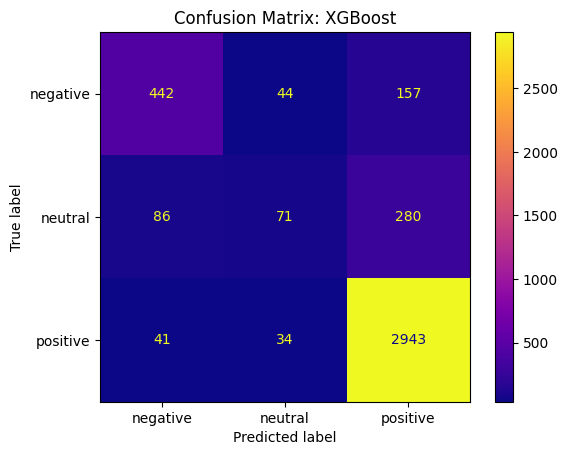

In [54]:
#evaluation
print("Classification Report: XGBoost:")
print(classification_report(y_valid_num, xgb_preds, digits=2))

#confusion matrix
cm = confusion_matrix(y_valid_num, xgb_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

disp.plot(cmap="plasma", values_format='d')

plt.title("Confusion Matrix: XGBoost")
plt.grid(False)
plt.show()

**Tuning XGBoost**

##### XGBoost already gave good results, so we decided to tune it to try and improve the performance even more, especially for the smaller classes like neutral and negative.”

In [55]:

#define a small XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
    )

#set lightweight parameter grid
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200]
}

#Gridsearch
grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',   
    cv=3,
    verbose=0,
    n_jobs=-1
)


#fit Gridsearch
grid_xgb.fit(X_train_tfidf, y_train_num)

#get best model
best_xgb = grid_xgb.best_estimator_
xgb_preds = best_xgb.predict(X_valid_tfidf)

print("Best parameters:", grid_xgb.best_params_)



Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


Best parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

**Note:** XGBoost Warning: “Parameters: { ‘use_label_encoder’ } are not used.”
This comes from the C++ backend, which doesn’t recognize use_label_encoder.
It appears if the parameter is passed via fit() or wrappers like GridSearchCV.
The warning does not affect model training or predictions.
It can’t be reliably suppressed because GridSearchCV clones the model internally, and each clone triggers the warning during __init__, before any user-side warning filters can take effect.

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       643
           1       0.49      0.17      0.26       437
           2       0.87      0.98      0.92      3018

    accuracy                           0.85      4098
   macro avg       0.72      0.61      0.64      4098
weighted avg       0.82      0.85      0.82      4098



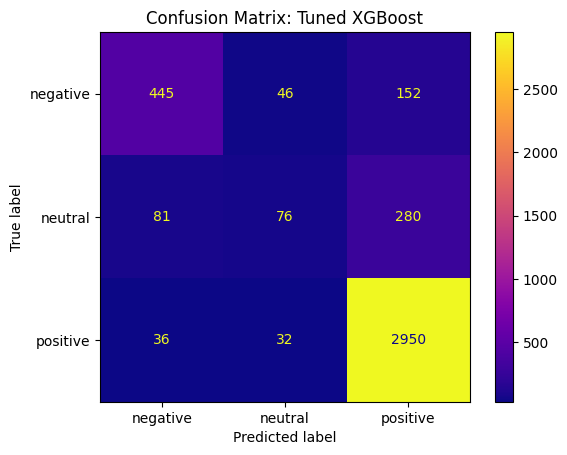

In [56]:

print(classification_report(y_valid_num, xgb_preds, digits=2))

#confusion matrix
cm = confusion_matrix(y_valid_num, xgb_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])
disp.plot(cmap="plasma", values_format='d')
plt.title("Confusion Matrix: Tuned XGBoost")
plt.grid(False)
plt.show()

**Tuning XGBoost result:**

#####  After tuning, XGBoost gave similar results to our other models, with good overall accuracy 85% and strong results for positive and negative reviews. Neutral reviews are still harder to catch, just like before.

Final Model Comparison:


,Metric,Logistic Regression (Balanced),Tuned LinearSVC,SVC (RBF Kernel),Tuned XGBoost
0,Accuracy,0.81,0.85,0.85,0.85
1,Negative Recall,0.80,0.81,0.80,0.69
2,Neutral Recall,0.51,0.32,0.32,0.17
3,Positive Recall,0.86,0.94,0.94,0.98
4,Macro F1-score,0.69,0.69,0.69,0.64


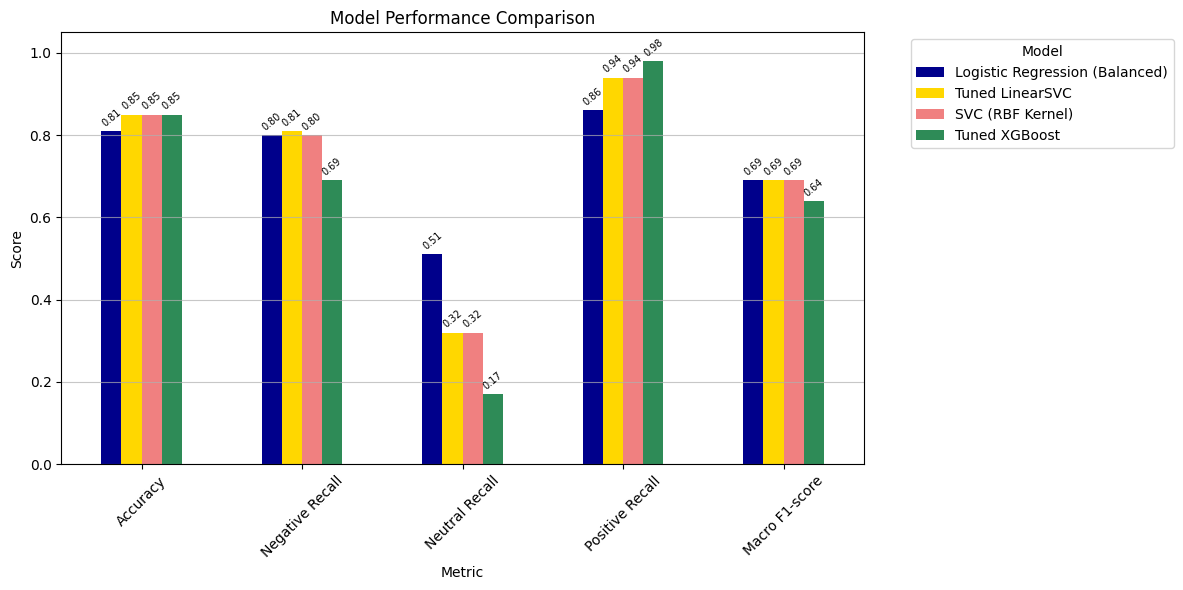

In [57]:
#set up comparison data
comparison_data = {
    "Metric": ["Accuracy", "Negative Recall", "Neutral Recall", "Positive Recall", "Macro F1-score"],
    "Logistic Regression (Balanced)": [0.81, 0.80, 0.51, 0.86, 0.69],
    "Tuned LinearSVC": [0.85, 0.81, 0.32, 0.94, 0.69],
    "SVC (RBF Kernel)": [0.85, 0.80, 0.32, 0.94, 0.69],
    "Tuned XGBoost": [0.85, 0.69, 0.17, 0.98, 0.64]
}

comparison_df = pd.DataFrame(comparison_data)

print("Final Model Comparison:")
display(comparison_df)

#plot models comparison
ax = comparison_df.set_index("Metric").plot(
    kind='bar',
    figsize=(12, 6),
    color=["darkblue", "gold", "lightcoral", "seagreen"],
    rot=45
)
for container in ax.containers:
    plt.bar_label(container, fmt='%.2f', fontsize=7, color='black', padding=2, rotation = 40)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y', alpha=0.7)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### **Summary of Model Comparison:**

##### While all models achieve a similar accuracy(around 85%), Logistic Regression with balanced class weights offers the best trade-off:

##### It preserves a strong negative recall 0.80 and a much better neutral recall 0.51 compared to LinearSVC, SVC with RBF, and XGBoost.

**Logistic Regression remains the best practical choice for detecting early service issues in customer reviews. We also successfully tested this model on truly unseen data, showing that it works well not just on training data but also on new reviews.**

### **Further Perfomance Improvement:**


**Further performance boosts:**

##### While further performance boosts may be achieved through deep hyperparameter tuning(larger grid or random search), advanced vectorization techniques (word embeddings like Word2Vec), ensemble models, or oversampling rare classes using SMOTE/RandomOversampler, or even training a DeepLearningModel like LSTM(RNN), but these approaches would significantly increase model complexity and training time.

##### If we were to continue improving the model, the next logical steps might be:

##### Apply Oversampling Techniques:
##### Using methods like SMOTE or RandomOverSampler to better balance the training set and improve the model’s recall, especially for neutral and negative reviews.

##### Use Word Embeddings Instead of TF-IDF:
##### Replacing TF-IDF with Word2Vec or fastText to better capture semantic relationships between words and help the model generalize even more effectively.

##### For the purpose of this project, we prioritized building a robust, interpretable, and efficient model, balancing practical results with simplicity.

##### Our final models already demonstrate strong performance on unseen data, particularly in the key areas of detecting negative and neutral reviews, which is critical for service quality monitoring.


### **Showcase**

#### We included a showcase to demonstrate how the model performs on individual examples. By displaying a few correctly predicted reviews for each sentiment class, we make the model’s behavior more transparent and show its practical value, especially in identifying negative or neutral feedback that may otherwise be overlooked. This makes it easier for non-technical users, like hotel managers, to trust and understand what the model is doing.

Note: Since we discovered late int he process that the original dataset already showed signs of preprocessing, we assume it was preprocessed in a way beforehand. To evaluate how well our model performs on truly unseen and natural input, we created an additional test set.

#### Generated Test Dataset (by ChatGPT)

To evaluate the model's generalization ability on unseen data, we created a realistic test set with the following properties:

##### Total Size:
- 1,000 reviews

##### Class Distribution:
- 30% negative → 300 reviews
- 20% neutral → 200 reviews
- 50% positive → 500 reviews

##### Neutral Class Style:
- Reviews contain mixed sentiments (e.g., one positive and one negative statement in the same text).
- Purpose: to reflect realistic ambiguity and make classification harder.

##### Style and Tone:
- Natural language with varied phrasing
- Proper grammar and spelling, no artificial structure
- About 10–15% of reviews include minor grammatical or spelling imperfections
- Mimicking real-world hotel guest reviews


In [58]:

#load the checking data
checking_data  = pd.read_csv("hotel_reviews_long.csv")

In [59]:
checking_data.head(10)

,index,review,label
0,0,The pictures online made the hotel seem much n...,negative
1,1,My stay at this hotel was generally okay. The ...,neutral
2,2,It was a standard experience—neither great nor...,neutral
3,3,I had an incredible stay at the hotel. From th...,positive
4,4,The pictures online made the hotel seem much n...,negative
5,5,The pictures online made the hotel seem much n...,negative
6,6,I had an incredible stay at the hotel. From th...,positive
7,7,This hotel went above and beyond to make our a...,positive
8,8,I had an incredible stay at the hotel. From th...,positive
9,9,I had an incredible stay at the hotel. From th...,positive


In [60]:
#preprocess the checking data
text = checking_data['review']
vec = vectorizer.transform(text)
predictions = log_reg_balanced.predict(vec)
checking_data['Predicted_Sentiment'] = predictions

In [61]:
#check the distribution of predicted sentiments
checking_data['label'].value_counts()

label
positive    500
negative    300
neutral     200
Name: count, dtype: int64

**Model Predictions on New Reviews**

#### To test the real-world usefulness of our sentiment model, we ran it on a set of fresh reviews. The table shows both the true and predicted sentiment labels. Most predictions matched the actual labels, including correct detection of negative and neutral feedback, which are especially valuable for hotel managers.

In [62]:
checking_data.head(10)

,index,review,label,Predicted_Sentiment
0,0,The pictures online made the hotel seem much n...,negative,negative
1,1,My stay at this hotel was generally okay. The ...,neutral,neutral
2,2,It was a standard experience—neither great nor...,neutral,positive
3,3,I had an incredible stay at the hotel. From th...,positive,positive
4,4,The pictures online made the hotel seem much n...,negative,negative
5,5,The pictures online made the hotel seem much n...,negative,negative
6,6,I had an incredible stay at the hotel. From th...,positive,positive
7,7,This hotel went above and beyond to make our a...,positive,positive
8,8,I had an incredible stay at the hotel. From th...,positive,positive
9,9,I had an incredible stay at the hotel. From th...,positive,positive


In [63]:
#print classification report
print("Classification Report on Unseen Data:")
print(classification_report(checking_data['label'], checking_data['Predicted_Sentiment'], digits=2))

Classification Report on Unseen Data:
              precision    recall  f1-score   support

    negative       0.81      0.87      0.84       300
     neutral       0.63      0.56      0.59       200
    positive       0.85      0.85      0.85       500

    accuracy                           0.80      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.79      0.80      0.79      1000



##### To test generalization, we applied our best Logistic Regression model to a new, unseen dataset. The results confirm that the model reliably transfers to new reviews:

-	Accuracy: 80%
-	Positive reviews were classified with Precision: 85%, Recall: 85%, matching earlier 		    validation performance.
-	Negative reviews were also captured strongly (Precision: 81%, Recall: 87%).
-	Neutral reviews were more challenging: Recall: 56%, what is consistent with previous results.

Iterpretation:
The slight drop in accuracy on the new test data likely results from differences in language style, vocabulary, or structure between the training and test sets. Logistic regression relies on the linear combination of features (e.g. word frequencies from TF-IDF), any shift in word usage or phrasing can reduce its ability to generalize.



**Conclusion:**

##### The model maintains strong generalization, especially for clearly positive or negative feedback, a useful tool for monitoring real-world customer sentiment.

### Practical Use

**Example Workflow: Review Monitoring System**

New customer review:
➔ Model predicts sentiment (positive / neutral / negative)
➔ If negative: Immediate alert to customer service
➔ If neutral: Flag for manual review
➔ If positive: Archive or trigger thank you message

**Benefits of Automatic Sentiment Detection:**

-	Find problems early, even if no star rating is given.
-	Act faster on negative and neutral feedback.
-	Track changes in customer satisfaction over time.
-	Save time by sorting thousands of reviews automatically.
-	Improve service quality based on what customers really say.

**Realworld examples where sentiment detection helps:**

-	Hotel feedback forms: Guests at places like Marriott or Hilton often write
comments without giving a star rating.
-	Chat messages: In apps like Booking.com or Airbnb, guests sometimes complain in
chat without leaving a formal review.
-	Poststay surveys: Companies like Expedia or TripAdvisor ask for comments and
these written texts often show more than just a rating.


## 4. [Conclusion](#Conclusion) 

**Key Takeaways and Best Model Choice**

In this project, we combined two powerful methods: Natural Language Processing (NLP) and Machine Learning (ML).

First, using NLP, we analyzed round 20k of hotel reviews to find out what guests talk about most, like room, staff, or location. We also looked at how they describe these aspects (e.g. “clean,” “rude,” “central”). This gave us a detailed picture of both positive and negative experiences, far beyond just star ratings.

Then, we trained and tested different machine learning models to automatically classify the overall sentiment of each review, positive, neutral, or negative.

After comparing multiple models, Logistic Regression with class balancing turned out to be the best choice. 
It:
	•	Handled imbalanced data better than others
	•	Detected neutral and negative reviews more accurately
	•	Was simpler and faster than more complex models like XGBoost or SVC
	•	Performed well on completely new (unseen) data

Even though models like XGBoost or SVC were slightly more accurate in some cases, Logistic Regression offered the best balance between performance, fairness(best recall in "neutral"), and interpretability.

The combination of NLP and Logistic Regression gives us a reliable tool to understand guest feedback deeply and automatically. It helps hotel teams act faster, focus on real issues, and improve service based on what customers truly say.

###

### [Final Model Evaluation](#FinalModelEvaluation) 

In [64]:
display(comparison_df)

,Metric,Logistic Regression (Balanced),Tuned LinearSVC,SVC (RBF Kernel),Tuned XGBoost
0,Accuracy,0.81,0.85,0.85,0.85
1,Negative Recall,0.80,0.81,0.80,0.69
2,Neutral Recall,0.51,0.32,0.32,0.17
3,Positive Recall,0.86,0.94,0.94,0.98
4,Macro F1-score,0.69,0.69,0.69,0.64
